In [74]:
# sys, file and nav packages:
import datetime as dt
import json

# math packages:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import spearmanr
from statsmodels.distributions.empirical_distribution import ECDF

# charting:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import seaborn as sns

import base64, io, IPython
from PIL import Image as PILImage
from IPython.display import Markdown as md
from IPython.display import display, Math, Latex

# set some parameters:
today = dt.datetime.now().date().strftime("%Y-%m-%d")
start_date = '2020-03-01'
end_date ='2021-05-31'

a_fail_rate = 100

unit_label = 'p/100m'
reporting_unit = 100

# name of the output folder:
name_of_project = 'dist_map'

# get your data:
df= pd.read_csv('checked_sdata_eos_2020_21.csv')

with open("river_basins.json", "r") as infile:
    river_bassins = json.load(infile)

dfBeaches = pd.read_csv("beaches_with_land_use_rates.csv")
dfCodes = pd.read_csv("codes_with_group_names_2015.csv")
dfDims = pd.read_csv("corrected_dims.csv")

# set the index of the beach data to location slug
dfBeaches.set_index('slug', inplace=True)
        
dfCodes.set_index("code", inplace=True)

# Changes in Spearmans $\rho$ as buffer size changes

Spearmans ranked test for correlation is being used to test the association of the number of objects found on the beach with the type of land use within a defined radius of the location where the objects were found.

The national survey on land use is the source for the classification of land use types. For every 100m² of the national territory there is an attributed land use classification based on the analysis of aerial images.

In [77]:
# this is the aggregated survey data that is being used
fd = df.copy()
fd['loc_dates'] = list(zip(fd.location.values, fd.date.values))
fd['date'] = pd.to_datetime(fd.date)
micro = [ 'G106', 'G103', 'G108', 'G107', 'G117', 'G115', 'G105',
       'G104', 'G113', 'G109', 'G123', 'G114', 'G118', 'G116', 'G111',
       'G119', 'G122', 'G112'] #G112 is pellets, now excluded 
fd = fd[~fd.code.isin(micro)]
fd.code = fd.code.replace('G207', 'G208')
# the location data for the surveys
dfb = dfBeaches.loc[fd.location.unique()].copy()

In [91]:
print('number of lakes considered:',len(fd[fd.w_t == 'l'].water_name_slug.unique()))
print('number of rivers considered:',len(fd[fd.w_t == 'r'].water_name_slug.unique()))

number of lakes considered: 11
number of rivers considered: 17


In [88]:
water_type = fd.groupby(['w_t','water_name_slug']).water_name_slug.nunique().reset_index()
water_type

ValueError: cannot insert water_name_slug, already exists

In [83]:
print('number of water bodies considered:', len(fd.water_name_slug.unique()))

number of water bodies considered: 28


In [7]:
print('number of categories found:',len(fd.code.unique()))
print('number of total items sampled:',fd.quantity.sum())

number of categories found: 211
number of total items sampled: 50469


In [8]:
# the landuse descriptors are integers, key them to a readable descriptor
# no27 is the results of intersecting buffer to Land use
label_keys = {
    1:"industrial",
    2:"residential",
    3:"government",
    4:"agg_buildings",
    5:"unk_building",
    6:"roads",
    7:"railways",
    8:"airports",
    9:"special",
    10:"recreational",
    11:"orchards",
    12:"vineyards",
    13:"horticulture",
    14:"arable",
    15:"meadows",
    16:"farmpastures",
    17:"alpinemeadows",
    18:"aplinepasteurs",
    19:"closed_forest",
    20:"open_forest",
    21:"brush_forest",
    22:"woods",
    23:"lakes",
    24:"rivers",
    25:"unproductive",
    26:"bareland",
    27:"glaciers"
}


key_labels = {v:k for k,v in label_keys.items()}

# group the land use into functional groups
group_parts = {'buildings':[2,3,4,5,9],
               'ind':[1],              
               'trans':[6,7,8],
               'recreation':[10],
               'agg':[11, 12, 13, 14, 15, 16, 18],
               'woods':[17,19,20,21,22],
               'water':[23,24],
               'unproductive':[25,26,27]
              }

# make column names based on the key values:
as_1827_part ={k:F"part_{v}" for k,v in label_keys.items()}

# map survey results to these aggregated luse features
som_cols = ['% to buildings',
            '% to ind',
            '% to trans',
            '% to recreation',
            '% to agg',
            '% to woods',
            '% to water',
            '% to unproductive',
                
]

# define functions to map luse data to survey locations
def aggregate_buffer_data(data, cols, bufferdata, label_keys, **kwargs):
    
    # make empty columns for the measured land use features
    for acol in cols:
        data[acol]= 0

    # assign values to each column
    for beach in data.index:
        for label in list(label_keys.values()):        
            try:
                new_data = bufferdata[(bufferdata.slug == beach)&(bufferdata.label == label)].AS18_27.values[0]
            except:
                new_data = 0
            data.loc[beach, label] = new_data
    return data

# account for the area attributed to water by removing the
# the value of water features from land use total
def adjusted_land_use(data, col_keys):
    # total land use
    data['luse_total'] = data.loc[:,list(col_keys.values())].sum(axis=1)

    # amount attributed to water
    data['water_value'] = data.loc[:, ['lakes','rivers']].sum(axis=1)

    # the adjsuted land use
    # remove the water value from land use stats
    data['adjusted_land_use'] = data.luse_total - data.water_value
    
    return data

# determine the ration of each landuse feature to the adjusted total for each buffer
def account_for_adj_luse(data, col_keys):
    for label in list(col_keys.values()):
        a_label = F"part_{label}"
        data[a_label] = data[label]/data['adjusted_land_use']
    return data

# aggregate the groups
def aggregate_the_luse_groups(data, groups, group_parts, as_1827_part):
    for a_group in group_parts.keys():
        part_groups = [as_1827_part[x] for x in group_parts[a_group]]
        new_group = F"% to {a_group}"
        data[new_group] = data.loc[:,part_groups].sum(axis=1)
    
    return data

# merge survey results to land use stats
def assign_luse_stat_to_survey_results(sdata, luse_data, som_cols):
    for a_beach in sdata.location.unique():
        for element in som_cols:
            sdata.loc[sdata.location == a_beach, element] = luse_data.loc[a_beach, element]
    return sdata

# apply method and check results
def check_hypothesis(this_data, some_codes, variables, method):
    myresults = {}
    for i,code in enumerate(some_codes):
        data = this_data[this_data.code == code]
        code_results ={code:{}}
        for j, n in enumerate(variables):
            corr, a_p = method(data[n], data[unit_label])
            if a_p <= 0.05:
                code_results[code].update({n:corr})
            else:
                code_results[code].update({n:'X'})
        myresults.update(code_results)
    
    return myresults

### 1500 meters codes with an association to a landuse feature

Where p <= 0.05 for Spearmans test for association.

In [9]:
no27 = pd.read_csv("noas04_27.csv")

# the buffer results from qgis
lu_1500 = no27[["AS18_27", "slug"]].copy()
lu_1500.rename(columns={'location':'slug'}, inplace=True)

# make a df with location slug, landuse label and land use value:
for a_num in lu_1500.AS18_27.unique():
    lu_1500.loc[lu_1500.AS18_27==a_num, "label"]=label_keys[a_num]

# the locations that need land use data
data = pd.DataFrame(index = fd.location.unique())

# records with a quantity greater than 30
abundant_codes = fd[fd.quantity > 20].code.unique()

# getting a list of the current landuse categories
add_these_cols = lu_1500.label.unique()

# counting the number of points inside the buffer for each category and location
bufferdata = lu_1500.groupby(['slug','label'], as_index=False).AS18_27.count()

these_groups = list(group_parts.keys())

some_data = aggregate_buffer_data(data, add_these_cols, bufferdata, label_keys)

sd_0 = adjusted_land_use(some_data, label_keys)

sd_1 = account_for_adj_luse(data, label_keys)

sd_1500 = aggregate_the_luse_groups(data, add_these_cols, group_parts, as_1827_part)
sd_1500['dist'] = 1500

fd_luse_1500 = assign_luse_stat_to_survey_results(fd, sd_1500,som_cols)    

this_data = fd_luse_1500[[unit_label,*som_cols, 'code']]

myresults = check_hypothesis(this_data, abundant_codes, som_cols, stats.spearmanr)

srho_results_1500 = pd.DataFrame.from_dict(myresults, orient='index')
srho_results_1500.fillna("X", inplace=True)
srho_results_1500['dist'] = 1500
srho_results_1500.replace('X', 0, inplace=True)


# the survey data with land use attached

In [10]:
key_labels.update({'luse_total':'total','water_value':'water_value', 'adjusted_land_use':'adjusted_land_use'})

In [11]:
cols_lu = ['recreational', 'farmpastures', 'closed_forest', 'rivers',
       'residential', 'roads', 'unproductive', 'industrial', 'railways',
       'woods', 'arable', 'special', 'government', 'unk_building', 'lakes',
       'meadows', 'horticulture', 'orchards', 'agg_buildings', 'bareland',
       'open_forest', 'vineyards', 'airports', 'brush_forest',
       'aplinepasteurs', 'alpinemeadows', 'glaciers','luse_total',
       'water_value', 'adjusted_land_use']

def make_col_totals(luse,key_labels, cols, colname='1500', id='id'):
    x = luse[cols].copy()
    
    x.loc[colname]= x.sum(numeric_only=True, axis=0)
    
    y = x.loc[colname]

    a_tot = pd.DataFrame(index=y.index, data=y)

    a_tot[id] = a_tot.index.map(lambda x: key_labels[x])
    
    return a_tot    

def agguse_groups(data, group_parts):
    wiw = {}
    for a_group in group_parts.keys():
        part_groups = [data.loc[x] for x in group_parts[a_group]]
        this_g = sum(part_groups)
        wiw.update({a_group:this_g})     
    
    return wiw

a_tot = make_col_totals(sd_1500,key_labels, cols_lu, colname='1500', id='id')
data = a_tot.set_index('id', drop=True)

yi= agguse_groups(data, group_parts)

lt1500 = pd.DataFrame.from_dict(yi, orient='index').append(data.loc[['total','water_value', 'adjusted_land_use']])

In [12]:
lt1500

,1500
agg,14927.0
buildings,17207.0
ind,1949.0
recreation,3599.0
trans,7592.0
unproductive,1326.0
water,30151.0
woods,14676.0
total,91427.0
water_value,30151.0


In [13]:
srho_results_1500.sort_values(by=['% to buildings', '% to woods', '% to ind', '% to recreation', '% to agg'], ascending=True).head()

,% to buildings,% to ind,% to trans,% to recreation,% to agg,% to woods,% to water,% to unproductive,dist
G904,-0.130361,-0.118668,-0.203706,0.0,0.000000,0.165436,0.0,0.156999,1500
G944,-0.109755,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,1500
G67,-0.102809,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,1500
G208,0.000000,0.000000,0.000000,0.0,-0.116457,-0.107231,0.0,-0.098033,1500
G137,0.000000,-0.104203,0.000000,0.0,0.000000,0.000000,0.0,0.000000,1500


### Calculate some key statistics ### 

In [14]:
abund_sum = fd[fd.code.isin(abundant_codes)].quantity.sum()
total_sum = fd.quantity.sum()
print('total items sampled (excluding micro):', fd.quantity.sum())
print('total most common items:', abund_sum)
print('proportion of most common items:', abund_sum/total_sum)
print('number of items found more than 20 times:', len(abundant_codes))

total items sampled (excluding micro): 50469
total most common items: 42537
proportion of most common items: 0.8428342150627117
number of items found more than 20 times: 36


In [15]:
abund_quantity = fd[fd.code.isin(abundant_codes)]
Dfabund_quantity = abund_quantity.groupby('code').agg({'quantity': 'sum', 'pcs_m':'mean'}).round(6) 
Dfabund_quantity.sort_values(by='quantity',ascending=False).head()
Dfabund_quantity.reset_index(inplace=True)
#Dfabund_quantity.pcs_m.unique()

In [16]:
# [add the description of items to the main dataframe]

df_codes = dfCodes.reset_index()
abund_codes_names = df_codes[df_codes.code.isin(abundant_codes)]
DfAdd = pd.merge(Dfabund_quantity, abund_codes_names, on = 'code')
srho_results_1500.index.name = 'code'

srho_results_1500.reset_index(inplace=True)
Df1500 = pd.merge(srho_results_1500, DfAdd, on = 'code')
Df1500.sort_values(by='quantity',ascending=False).head()


,code,% to buildings,% to ind,% to trans,% to recreation,% to agg,% to woods,% to water,% to unproductive,dist,...,description,source,source_two,source_three,parent_code,direct,single_use,micro,ospar_code,groupname
0,G27,0.329882,0.000000,0.345363,0.297737,-0.283219,-0.179103,0.168776,-0.282892,1500,...,Cigarette filters,Tobacco,Where does it come from,none,Parent code,True,True,False,64,tobacco
33,Gfrags,0.117534,0.000000,0.117785,0.201862,0.000000,0.000000,0.110850,0.000000,1500,...,Fragmented plastics,Undefined,None,None,Parent code,True,False,False,46,plastic pieces
34,Gfoam,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.125314,-0.100961,1500,...,Expanded polystyrene,Undefined,Packaging,Construction,Parent code,False,False,False,46,infrastructure
3,G30,0.248042,0.149508,0.279077,0.290929,-0.155087,-0.125135,0.106595,-0.109077,1500,...,"Food wrappers; candy, snacks",Packaging,Food and drink,none,Parent code,True,True,False,19,food and drink
4,G67,-0.102809,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1500,...,Industrial sheeting,Utility items,Industry,none,Parent code,False,False,False,40,agriculture


In [17]:
# [Correct some description labels]

Df1500_vis = Df1500.copy()
Df1500_vis = Df1500_vis.sort_values(by='quantity',ascending=False)
Df1500_vis['description'] = Df1500_vis['description'].replace('Industrial pellets (nurdles)', 'Pellets') 
Df1500_vis['description'] = Df1500_vis['description'].replace('Glass drink bottles, pieces', 'Glass bottles and pieces') 
Df1500_vis['description'] = Df1500_vis['description'].replace('Food wrappers; candy, snacks', 'Food wrappers') 
Df1500_vis['description'] = Df1500_vis['description'].replace('Food wrappers; candy, snacks', 'Food wrappers') 
Df1500_vis['description'] = Df1500_vis['description'].replace('Foam packaging/insulation/polyurethane', 'Foam packaging for insulation') 
Df1500_vis['description'] = Df1500_vis['description'].replace('Packaging films nonfood or unknown', 'Packaging films (not food-related)') 
Df1500_vis['description'] = Df1500_vis['description'].replace('Lids unidentified', 'Other lids') 
Df1500_vis['description'] = Df1500_vis['description'].replace('Tobacco; plastic packaging, containers', 'Plastic packaging for tobacco') 
Df1500_vis['description'] = Df1500_vis['description'].replace('Fireworks paper tubes and fragments', 'Fireworks (paper parts)') 
Df1500_vis['description'] = Df1500_vis['description'].replace('Diapers - wipes', 'Diapers and wipes') 
Df1500_vis['description'] = Df1500_vis['description'].replace('Foamed items & pieces (non packaging/insulation) foamed sponge material', 'Foam items and pieces (not insulation)') 
Df1500_vis['description'] = Df1500_vis['description'].replace('Labels, bar codes', 'Labels and bar codes') 
Df1500_vis['description'] = Df1500_vis['description'].replace('Sanitary pads /panty liners/tampons and applicators', 'Sanitary pads, tampons and applicators') 
Df1500_vis['description'] = Df1500_vis['description'].replace('Pellet mass from injection molding', 'Pellet mass') 
Df1500_vis['description'] = Df1500_vis['description'].replace('Bags; plastic shopping/carrier/grocery and pieces', 'Plastic bags and pieces') 
Df1500_vis['description'] = Df1500_vis['description'].replace('Lids for chemicals, detergents (non-food)', 'Lids for chemicals and detergents') 
Df1500_vis['description'] = Df1500_vis['description'].replace('Coverings; plastic packaging, sheeting for protecting large cargo items', 'Plastic sheeting for large cargo items') 
Df1500_vis['description'] = Df1500_vis['description'].replace('Construction material; bricks, pipes, cement', 'Construction materials (bricks, pipes, cement)') 
Df1500_vis['description'] = Df1500_vis['description'].replace('Fireworks; rocket caps, exploded parts & packaging', 'Fireworks (rocket caps, exploded parts and packaging)') 
Df1500_vis['description'] = Df1500_vis['description'].replace('Foamed EVA (flexible plastic) for crafts & watersports', 'Foamed EVA') 
Df1500_vis['description'] = Df1500_vis['description'].replace('Metal bottle caps, lids & pull tabs from cans', 'Metal bottle caps, lids and pull tabs from cans') 
Df1500_vis['description'] = Df1500_vis['description'].replace('Lid/cap rings from plastic bottles/containers', 'Lids and cap rings from plastic bottles') 
Df1500_vis['description'] = Df1500_vis['description'].replace('Tissue, toilet paper, napkins, paper towels', 'Tissues, toilet paper and paper towels') 
Df1500_vis['description'] = Df1500_vis['description'].replace('Cotton bud/swab sticks', 'Cotton buds and swab sticks') 
Df1500_vis['description'] = Df1500_vis['description'].replace('Foil wrappers, aluminum foil', 'Aluminum foil') 
Df1500_vis['description'] = Df1500_vis['description'].replace('Clothing, towels & rags', 'Clothing and rags') 
Df1500_vis['description'] = Df1500_vis['description'].replace('Food containers single use foamed or plastic', 'Plastic food containers') 
Df1500_vis['description'] = Df1500_vis['description'].replace('Plastic fragments angular <5mm', 'Angular plastic fragments (< 0.5 cm)') 
Df1500_vis['description'] = Df1500_vis['description'].replace('Plastic fragments rounded <5mm', 'Round plastic fragments (< 0.5 cm)') 
Df1500_vis['description'] = Df1500_vis['description'].replace('Foamed  plastic <5mm', 'Foam plastic (< 0.5 cm)') 
Df1500_vis['description'] = Df1500_vis['description'].replace('Styrofoam < 5mm', 'Styrofoam fragments (< 0.5 cm)') 
Df1500_vis['description'] = Df1500_vis['description'].replace('Glass or ceramic fragments > 2.5 cm', 'Glass and ceramic fragments (> 2.5 cm)') 

Df1500Vis = Df1500_vis.iloc[:, 0:16]

Df1500Vis = Df1500Vis.drop(['dist', 'material', 'quantity', 'pcs_m','code', 'source','source_two'], axis=1)

Df1500Vis.set_index('description', inplace=True)
Df1500Vis.columns = ['Buildings','Industries', 'Roads','Recreational','Agriculture','Forests', 'Rivers/canals','Unproductive']
Df1500Vis = Df1500Vis[['Buildings','Industries', 'Recreational','Agriculture','Forests', 'Unproductive', 'Roads','Rivers/canals']]
Df1500Vis.iloc[20:22,:]

,Buildings,Industries,Recreational,Agriculture,Forests,Unproductive,Roads,Rivers/canals
description,,,,,,,,
"Fireworks (rocket caps, exploded parts and packaging)",-0.130361,-0.118668,0.0,0.0,0.165436,0.156999,-0.203706,0.0
Plastic bags and pieces,0.000000,0.123729,0.0,0.0,0.111189,0.000000,0.000000,0.0


In [18]:
# [Assign types to item categories]

Df1500.loc[Df1500.source.isin(['Tobacco']) |
           Df1500.source_two.isin(['Smoking related']),'Type'] ='Tobacco'

Df1500.loc[Df1500.source.isin(['Industry','Construction', 'Industrial', 'Manufacturing']) |
           Df1500.source_two.isin(['Industry','Construction', 'Industrial','Manufacturing'])  | 
           Df1500.source_three.isin(['Industry','Construction', 'Industrial','Manufacturing']),'Type'] ='Industry'

Df1500.loc[Df1500.source.isin(['Personal hygiene']) |
           Df1500.source_two.isin(['Water treatment']),'Type'] ='Sanitary'

Df1500.loc[Df1500.description.isin(['Paper packaging']) |
           Df1500.description.isin(['Packaging films nonfood or unknown']),'Type'] ='Packaging (non-food)'

Df1500.loc[Df1500.source_two.isin(['Food and drink']) |
           Df1500.description.isin(['Foil wrappers, aluminum foil']) |
           Df1500.source_two.isin(['Food and drinks']),'Type'] ='Food and drinks'

Df1500.loc[Df1500.description.isin(['Plastic fragments angular <5mm']) |
           Df1500.description.isin(['Styrofoam < 5mm']) |
           Df1500.description.isin(['Plastic fragments rounded <5mm']) |
           Df1500.description.isin(['Foamed  plastic <5mm']) |
           Df1500.description.isin(['Fragmented plastics']),'Type'] ='Plastic fragments and pieces'
Df1500.loc[Df1500.Type.isna(), 'Type'] = 'Others'
Df1500[Df1500.Type == 'Others'].description.unique()

array(['Glass or ceramic fragments > 2.5 cm',
       'Lid/cap rings from plastic bottles/containers',
       'Shotgun cartridges', 'Lids for chemicals, detergents (non-food)',
       'Lids unidentified',
       'Foamed EVA (flexible plastic) for crafts & watersports',
       'Fireworks; rocket caps, exploded parts & packaging',
       'Clothing, towels & rags', 'Fireworks paper tubes and fragments',
       'Foamed items & pieces (non packaging/insulation) foamed sponge material',
       'Ribbons and bows', 'Labels, bar codes'], dtype=object)

In [19]:
DfTypePl = Df1500.groupby(['Type','material']).quantity.sum().reset_index()
DfTypePl = DfTypePl[DfTypePl.material=='Plastic']
DfTypePl.columns = ['Type','Plastic','plast_qu']

In [20]:
DfType = Df1500.groupby('Type').quantity.sum().reset_index()
DfType.sort_values(by='quantity',ascending=False,inplace=True)
DfType['Proportion'] = (DfType.quantity/DfType.quantity.sum())*100
DfType.Proportion = DfType.Proportion.round(decimals=1)
DfType.loc[DfType.Type=='Industry','Items'] = 'Expanded polystyrene, Industrial sheeting, Pellets, Foam packaging for insulation, Plastic construction waste, Ceramic tile and pieces, Plastic sheeting for large cargo items, Construction materials (bricks, pipes, cement), Pellet mass'
DfType.loc[DfType.Type=='Plastic fragments and pieces','Items'] = 'Fragmented plastics' 
DfType.loc[DfType.Type=='Tobacco','Items'] = 'Cigarette filters; Plastic packaging for tobacco'
DfType.loc[DfType.Type=='Sanitary','Items'] = 'Sanitary pads, tampons and applicators; Diapers and wipes; Tissues, toilet paper and paper towels, Cotton buds and swab sticks'
DfType.loc[DfType.Type=='Packaging (non-food)','Items'] = 'Paper packaging, Packaging films (not food-related)'
DfType.loc[DfType.Type=='Food and drinks','Items'] = 'Food wrappers, Glass bottles and pieces, Metal bottle caps, lids and pull tabs from cans, Drink lids, Aluminum foil, Plastic food containers, Plastic bags and pieces'
DfType.loc[DfType.Type=='Others','Items'] = 'Lids and cap rings from plastic bottles, Others lids, Shotgun cartridges, Foam items and pieces (not insulation), Fireworks (rocket caps, exploded parts and packaging), Lids for chemicals and detergents, Labels and bar codes, Foamed EVA, Glass and ceramic fragments (> 2.5 cm), Fireworks (paper parts), Clothing and rags, Ribbons and bows, Octopus pots'
print('Total industrial items over total macrolitter items:', DfType[DfType.Type=='Industry'].quantity.sum()/total_sum )

Total industrial items over total macrolitter items: 0.22471219956805166


In [21]:
DfTypeAll = pd.merge(DfType, DfTypePl, on = 'Type')

In [22]:
DfTypeAll['plast_prop'] = ((DfTypeAll.plast_qu)/(DfTypeAll.quantity)*100).round(1)
DfTypeAll

,Type,quantity,Proportion,Items,Plastic,plast_qu,plast_prop
0,Industry,11341,26.7,"Expanded polystyrene, Industrial sheeting, Pel...",Plastic,10985,96.9
1,Tobacco,9134,21.5,Cigarette filters; Plastic packaging for tobacco,Plastic,9134,100.0
2,Food and drinks,8038,18.9,"Food wrappers, Glass bottles and pieces, Metal...",Plastic,4681,58.2
3,Plastic fragments and pieces,7400,17.4,Fragmented plastics,Plastic,7400,100.0
4,Others,3159,7.4,"Lids and cap rings from plastic bottles, Other...",Plastic,2742,86.8
5,Sanitary,2450,5.8,"Sanitary pads, tampons and applicators; Diaper...",Plastic,2209,90.2
6,Packaging (non-food),1015,2.4,"Paper packaging, Packaging films (not food-rel...",Plastic,894,88.1


In [23]:
DfType.sort_values(by='quantity',ascending=False)
DfType.to_csv('C:/Users/schre086/datasets/Switzerland/table_type.csv', index = False, header=True)

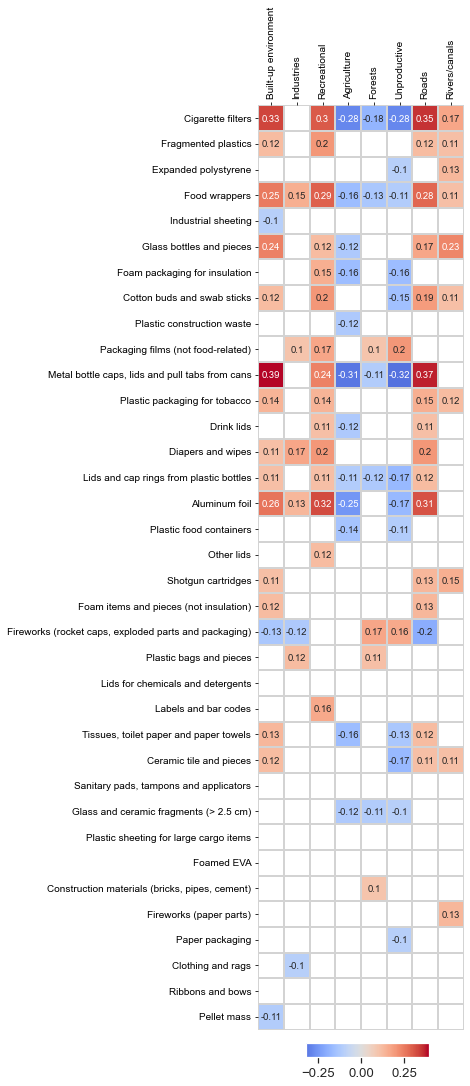

In [24]:
# [Correlation matrix plot]

fig, ax= plt.subplots(figsize=(17,17))


sns.set(font_scale=1.2)

ax = sns.heatmap(Df1500Vis.round(decimals=2), annot=True, fmt="g", cmap='coolwarm', annot_kws={"size":9.5}, center =0, mask=Df1500Vis==0, square = True, 
                linewidths=0.1,linecolor="lightgrey", cbar = False, ax = ax)
#axes[1] = sns.heatmap(Df2000Vis.round(decimals=2).iloc[21:], annot=True, fmt="g", cmap='coolwarm', annot_kws={"size":12}, center =0, mask=Df2000Vis.iloc[21:]==0, square = True, 
 #               linewidths=0.1,linecolor="lightgrey", cbar = False, ax = axes[1])

ax.set_ylabel('')
#axes[1].set_ylabel('')

ax.xaxis.tick_top() 
#axes[1].xaxis.tick_top() 

ax.yaxis.tick_left()
#axes[1].yaxis.tick_left()

ax.xaxis.set_label_position('top')
#axes[1].xaxis.set_label_position('top')

ax.set_xticklabels(['Built-up environment','Industries', 'Recreational', 'Agriculture', 'Forests', 'Unproductive', 'Roads', 'Rivers/canals'],rotation=90)
#axes[1].set_xticklabels(['Buildings','Industries', 'Recreational', 'Agriculture', 'Forests', 'Unproductive', 'Roads', 'Rivers/canals'],rotation=90)
             
ax_divider = make_axes_locatable(ax)
#cax = ax_divider.append_axes(anchor=(1.0,0.0), size = '2%', pad = '5%')
axins = inset_axes(ax,
                   width="60%",  # width = 5% of parent_bbox width
                   height="1.5%",  # height : 50%
                   loc='lower center',
                   bbox_to_anchor=(0.03, -0.03, 1, 1),
                   bbox_transform=ax.transAxes, 
                   borderpad=0
                   )

fig.colorbar(ax.get_children()[0], cax = axins, orientation = 'horizontal', extendfrac='auto')
#cax.xaxis.set_ticks_position('top') 
#axins.set_clim(-0.2, 0.2)
#plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=1.5, hspace=None)

plt.savefig('C:/Users/schre086/figures/land_use_ch/corr_matrix_1500.png', bbox_inches='tight')

plt.show()Df1500Vis

In [76]:
rho = Df1500Vis.corr(method='spearman')
pval = Df1500Vis.corr(method=lambda x, y: spearmanr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [0.01,0.05,0.1] if x<=t]))
rho.round(2).astype(str) + p

,Buildings,Industries,Recreational,Agriculture,Forests,Unproductive,Roads,Rivers/canals
Buildings,1.0***,0.34**,0.63***,-0.49***,-0.49***,-0.57***,0.93***,0.49***
Industries,0.34**,1.0***,0.45***,-0.17,-0.03,-0.12,0.39**,-0.01
Recreational,0.63***,0.45***,1.0***,-0.43***,-0.34**,-0.32*,0.67***,0.25
Agriculture,-0.49***,-0.17,-0.43***,1.0***,0.54***,0.64***,-0.47***,-0.01
Forests,-0.49***,-0.03,-0.34**,0.54***,1.0***,0.65***,-0.53***,-0.23
Unproductive,-0.57***,-0.12,-0.32*,0.64***,0.65***,1.0***,-0.52***,-0.17
Roads,0.93***,0.39**,0.67***,-0.47***,-0.53***,-0.52***,1.0***,0.45***
Rivers/canals,0.49***,-0.01,0.25,-0.01,-0.23,-0.17,0.45***,1.0***


In [25]:
DfCorr = Df1500.iloc[:,:14]
DfCorr = DfCorr.drop(['dist','material'], axis=1)
DfCorr[DfCorr !=0].count()

code                 36
% to buildings       17
% to ind              7
% to trans           16
% to recreation      15
% to agg             12
% to woods            9
% to water           10
% to unproductive    15
quantity             36
pcs_m                36
description          36
dtype: int64

In [26]:
print('buildings',DfCorr.loc[DfCorr['% to buildings']!=0, 'quantity'].sum())
print('industry',DfCorr.loc[DfCorr['% to ind']!=0, 'quantity'].sum())
print('road network',DfCorr.loc[DfCorr['% to trans']!=0, 'quantity'].sum())
print('recreation',DfCorr.loc[DfCorr['% to recreation']!=0, 'quantity'].sum())
print('agriculture',DfCorr.loc[DfCorr['% to agg']!=0, 'quantity'].sum())
print('forest',DfCorr.loc[DfCorr['% to woods']!=0, 'quantity'].sum())
print('rivers',DfCorr.loc[DfCorr['% to water']!=0, 'quantity'].sum())
print('unproductive',DfCorr.loc[DfCorr['% to unproductive']!=0, 'quantity'].sum())

buildings 29818
industry 6032
road network 27873
recreation 29645
agriculture 19889
forest 14831
rivers 29710
unproductive 24654


In [27]:
print('Total plastic items:', Df1500_vis[Df1500_vis.material=='Plastic'].quantity.sum())
print('Proportion plastic items over all macrolitter items:', Df1500_vis[Df1500_vis.material=='Plastic'].quantity.sum()/Df1500_vis.quantity.sum())
print('Proportion glass items over all macrolitter items:',Df1500_vis[Df1500_vis.material=='Glass'].quantity.sum()/Df1500_vis.quantity.sum())
print('Proportion paper items over all macrolitter items:',Df1500_vis[Df1500_vis.material=='Paper'].quantity.sum()/Df1500_vis.quantity.sum())
print('Proportion metal items over all macrolitter items:',Df1500_vis[Df1500_vis.material=='Metal'].quantity.sum()/Df1500_vis.quantity.sum())
print('Proportion cloth items over all macrolitter items:',Df1500_vis[Df1500_vis.material=='Cloth'].quantity.sum()/Df1500_vis.quantity.sum())

Total plastic items: 38045
Proportion plastic items over all macrolitter items: 0.8943978183698897
Proportion glass items over all macrolitter items: 0.06269835672473376
Proportion paper items over all macrolitter items: 0.011425347344664645
Proportion metal items over all macrolitter items: 0.028704422032583398
Proportion cloth items over all macrolitter items: 0.002774055528128453


In [28]:
print('proportion top 36 items over all items:',Df1500.quantity.sum()/fd.quantity.sum())
print('number of top 36 items:', Df1500.quantity.sum())


proportion top 36 items over all items: 0.8428342150627117
number of top 36 items: 42537


In [29]:
Df1500 =Df1500.sort_values(by='quantity',ascending=False)
DfTop20 = Df1500.iloc[:20,:]
DfTop20 = DfTop20[['description', 'quantity','Type']]
print('total of top 20 items:',DfTop20.quantity.sum())
print('proportion of top 20 items over all macrolitter item sampled:',DfTop20.quantity.sum()/total_sum)

total of top 20 items: 39656
proportion of top 20 items over all macrolitter item sampled: 0.7857496681130991


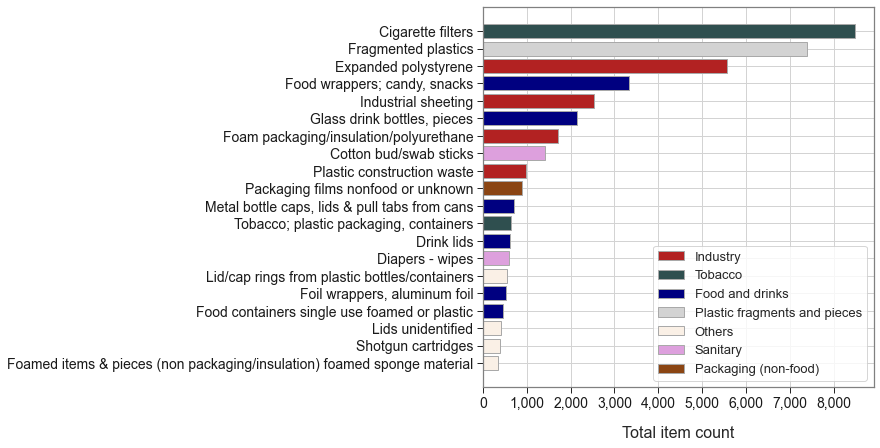

In [30]:
# [Top 20 items plot]

fig, ax = plt.subplots(figsize=(7,7))
colors = {'Industry': 'firebrick', 'Tobacco': 'darkslategrey', 'Food and drinks': 'navy', 'Plastic fragments and pieces':'lightgrey',
         'Others':'linen','Sanitary':'plum','Packaging (non-food)':'saddlebrown'}
N = 3
ind = np.arange(N)
width = 0.6

labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]

ax.barh(DfTop20.description, DfTop20.quantity, color=[colors[i] for i in DfTop20['Type']], edgecolor='darkgrey')
ax.invert_yaxis()  
ax.set_ylabel('')
ax.set_xticks([0,1000,2000,3000,4000,5000,6000,7000,8000])
ax.set_xticklabels([0,'1,000','2,000','3,000','4,000','5,000','6,000','7,000','8,000'])

ax.set_xlabel('Total item count', fontsize=16, labelpad =15)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.tick_params(labelcolor='k', labelsize=14, width=1)
ax.yaxis.grid(color='lightgray')
ax.xaxis.grid(color='lightgray')
ax.set_facecolor('white')

plt.legend(handles, labels, fontsize=13,facecolor='white')
for ha in ax.legend_.legendHandles:
    ha.set_edgecolor("darkgrey")

plt.grid(True)
ax.spines['top'].set_color('0.5')
ax.spines['right'].set_color('0.5')
ax.spines['bottom'].set_color('0.5')
ax.spines['left'].set_color('0.5')

plt.savefig('C:/Users/schre086/figures/land_use_ch/top_20items.png', bbox_inches='tight')

plt.show()

In [31]:
cols_table = ['quantity','pcs_m','material', 'description', 'Type']

Df1500_vis = Df1500[cols_table]
Df1500_vis['% of total'] = ((Df1500_vis.quantity)/total_sum)*100
Df1500_vis = Df1500_vis[['description','quantity','% of total','pcs_m','Type','material']]
Df1500_vis.head()
#Df1500_vis.to_csv('C:/Users/schre086/datasets/Switzerland/export_table.csv', index = False, header=True)

C:\Users\schre086\AppData\Local\Temp/ipykernel_8292/3650841902.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Df1500_vis['% of total'] = ((Df1500_vis.quantity)/total_sum)*100


,description,quantity,% of total,pcs_m,Type,material
0,Cigarette filters,8485,16.812301,0.542772,Tobacco,Plastic
33,Fragmented plastics,7400,14.662466,0.592176,Plastic fragments and pieces,Plastic
34,Expanded polystyrene,5563,11.022608,0.435233,Industry,Plastic
3,"Food wrappers; candy, snacks",3325,6.588203,0.236451,Food and drinks,Plastic
4,Industrial sheeting,2534,5.020904,0.189326,Industry,Plastic


In [32]:
DfCorr_1500 = Df1500.iloc[:,:14]
DfCorr_1500 = DfCorr_1500.iloc[:,1:9]
#DfCorr_3500 = DfCorr_3500.drop(['dist','material'], axis=1)
sign_corr_1500 = DfCorr_1500[DfCorr_1500 !=0].count().to_frame()
sign_corr_1500.sort_values(by=0,ascending=False)#.iloc[5:,:]
DfCorr_1500.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36 entries, 0 to 28
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   % to buildings     36 non-null     float64
 1   % to ind           36 non-null     float64
 2   % to trans         36 non-null     float64
 3   % to recreation    36 non-null     float64
 4   % to agg           36 non-null     float64
 5   % to woods         36 non-null     float64
 6   % to water         36 non-null     float64
 7   % to unproductive  36 non-null     float64
dtypes: float64(8)
memory usage: 2.5 KB


In [49]:
cols_corr = ['% to buildings',  '% to ind', '% to recreation', '% to agg', '% to woods', '% to unproductive', '% to trans'] 

trans = ['% to water']

Df1500['corr_count'] = Df1500[cols_corr].apply(lambda x: (x!=0).sum(), axis=1)
Df1500['pos_corr_count'] = Df1500[cols_corr].apply(lambda x: (x>0).sum(), axis=1)
Df1500['corr_trans'] = Df1500[trans].apply(lambda x: (x>0).sum(), axis=1)
#Df3500.info()

cols_to_drop = [9,12,14,15,16,17,18,19,20,21,22]
Df1500_new = Df1500.drop(Df1500.columns[cols_to_drop],axis=1)

Df1500_new.sort_values(by=['pos_corr_count', 'corr_trans'],ascending=False).head(15)

,code,% to buildings,% to ind,% to trans,% to recreation,% to agg,% to woods,% to water,% to unproductive,quantity,pcs_m,description,Type,corr_count,pos_corr_count,corr_trans
3,G30,0.248042,0.149508,0.279077,0.290929,-0.155087,-0.125135,0.106595,-0.109077,3325,0.236451,"Food wrappers; candy, snacks",Food and drinks,7,4,1
10,G941,0.000000,0.104196,0.000000,0.168347,0.000000,0.100867,0.000000,0.198360,894,0.062461,Packaging films nonfood or unknown,Packaging (non-food),4,4,0
7,G98,0.111053,0.170446,0.200282,0.199990,0.000000,0.000000,0.000000,0.000000,588,0.035440,Diapers - wipes,Sanitary,4,4,0
11,G177,0.264759,0.128450,0.314897,0.318288,-0.252309,0.000000,0.000000,-0.168237,521,0.032876,"Foil wrappers, aluminum foil",Food and drinks,6,4,0
0,G27,0.329882,0.000000,0.345363,0.297737,-0.283219,-0.179103,0.168776,-0.282892,8485,0.542772,Cigarette filters,Tobacco,6,3,1
33,Gfrags,0.117534,0.000000,0.117785,0.201862,0.000000,0.000000,0.110850,0.000000,7400,0.592176,Fragmented plastics,Plastic fragments and pieces,3,3,1
1,G200,0.243086,0.000000,0.165440,0.124722,-0.119961,0.000000,0.233502,0.000000,2136,0.161710,"Glass drink bottles, pieces",Food and drinks,4,3,1
5,G95,0.121520,0.000000,0.190023,0.197952,0.000000,0.000000,0.107051,-0.152552,1406,0.106788,Cotton bud/swab sticks,Sanitary,4,3,1
17,G25,0.141495,0.000000,0.148774,0.144165,0.000000,0.000000,0.124155,0.000000,649,0.052383,"Tobacco; plastic packaging, containers",Tobacco,3,3,1
12,G178,0.385461,0.000000,0.369457,0.238783,-0.312356,-0.107013,0.000000,-0.317335,700,0.043938,"Metal bottle caps, lids & pull tabs from cans",Food and drinks,6,3,0


In [65]:
DfLocalItems = Df1500_new[Df1500_new.corr_count >= 4]
print('total quantity of items likely to be locally littered:', DfLocalItems.quantity.sum())
print('proportion of items likely to be locally littered among top items:', (DfLocalItems.quantity.sum()/abund_sum)*100)
print('list of categories in that group:', DfLocalItems.description.unique())
print('number of categories in that group:', len(DfLocalItems.description.unique()))

## about 44% if you include transport as a variable to consider in the correlation count 

total quantity of items likely to be locally littered: 19138
proportion of items likely to be locally littered among top items: 44.991419235018924
list of categories in that group: ['Cigarette filters' 'Food wrappers; candy, snacks'
 'Glass drink bottles, pieces' 'Cotton bud/swab sticks'
 'Packaging films nonfood or unknown'
 'Metal bottle caps, lids & pull tabs from cans' 'Diapers - wipes'
 'Lid/cap rings from plastic bottles/containers'
 'Foil wrappers, aluminum foil'
 'Fireworks; rocket caps, exploded parts & packaging'
 'Tissue, toilet paper, napkins, paper towels']
number of categories in that group: 11


In [66]:
DfUbiItems = Df1500_new[(Df1500_new.corr_count <= 3) & (Df1500_new.corr_trans >= 1)]

print('total quantity of ubiquituous items:', DfUbiItems.quantity.sum())
print('proportion of ubiquitous items:',(DfUbiItems.quantity.sum()/abund_sum)*100 )
print('list of categories in that group:', DfUbiItems.description.unique())
print('number of categories in that group:', len(DfUbiItems.description.unique()))

total quantity of ubiquituous items: 14358
proportion of ubiquitous items: 33.75414345158333
list of categories in that group: ['Fragmented plastics' 'Expanded polystyrene'
 'Tobacco; plastic packaging, containers' 'Shotgun cartridges'
 'Ceramic tile and pieces' 'Fireworks paper tubes and fragments']
number of categories in that group: 6


In [67]:
DfOthers = Df1500_new[(Df1500_new.corr_trans == 0) & (Df1500_new.corr_count <= 3)]
print('total quantity of other items:', DfOthers.quantity.sum())
print('proportion of other items:',(DfOthers.quantity.sum()/abund_sum)*100 )
print('list of categories in that group:', DfOthers.description.unique())
print('number of categories in that group:', len(DfOthers.description.unique()))

DfOthers[DfOthers.description == 'Foam packaging/insulation/polyurethane']

total quantity of other items: 9041
proportion of other items: 21.254437313397748
list of categories in that group: ['Industrial sheeting' 'Foam packaging/insulation/polyurethane'
 'Plastic construction waste' 'Drink lids'
 'Food containers single use foamed or plastic' 'Lids unidentified'
 'Foamed items & pieces (non packaging/insulation) foamed sponge material'
 'Bags; plastic shopping/carrier/grocery and pieces'
 'Lids for chemicals, detergents (non-food)' 'Labels, bar codes'
 'Sanitary pads /panty liners/tampons and applicators'
 'Glass or ceramic fragments > 2.5 cm'
 'Coverings; plastic packaging, sheeting for protecting large cargo items'
 'Foamed EVA (flexible plastic) for crafts & watersports'
 'Construction material; bricks, pipes, cement' 'Paper packaging'
 'Clothing, towels & rags' 'Ribbons and bows'
 'Pellet mass from injection molding']
number of categories in that group: 19


,code,% to buildings,% to ind,% to trans,% to recreation,% to agg,% to woods,% to water,% to unproductive,quantity,pcs_m,description,Type,corr_count,pos_corr_count,corr_trans
35,G74,0.0,0.0,0.0,0.150175,-0.156292,0.0,0.0,-0.15839,1702,0.131321,Foam packaging/insulation/polyurethane,Industry,3,1,0


In [59]:
# checking if total proportion is 100%

print('total proportion of groups:',((DfOthers.quantity.sum()/abund_sum)*100) 
      + ((DfUbiItems.quantity.sum()/abund_sum)*100) 
      + ((DfLocalItems.quantity.sum()/abund_sum)*100))

total proportion of groups: 100.0


### 2000 meters codes with an association to a landuse feature

Where p <= 0.05 for Spearmans test for association.

In [17]:
# the buffer results from qgis
lu_2000 = pd.read_csv('luse_2000.csv')
lu_2000.rename(columns={'location':'slug'}, inplace=True)

# make a df with location slug, landuse label and land use value:
for a_num in lu_2000.AS18_27.unique():
    lu_2000.loc[lu_2000.AS18_27==a_num, "label"]=label_keys[a_num]

# the locations that need land use data
data = pd.DataFrame(index = fd.location.unique())

# records with a quantity greater than 20
abundant_codes = fd[fd.quantity > 20].code.unique()

# getting a list of the current landuse categories
add_these_cols = lu_2000.label.unique()

# counting the number of points inside the buffer for each category and location
bufferdata = lu_2000.groupby(['slug','label'], as_index=False).AS18_27.count()

these_groups = list(group_parts.keys())

some_data = aggregate_buffer_data(data, add_these_cols, bufferdata, label_keys)

sd_0 = adjusted_land_use(some_data, label_keys)

sd_1 = account_for_adj_luse(data, label_keys)

sd_2000 = aggregate_the_luse_groups(data, add_these_cols, group_parts, as_1827_part)
sd_2000['dist'] = 2000

fd_luse = assign_luse_stat_to_survey_results(fd, sd_2000,som_cols)    

this_data = fd_luse[[unit_label,*som_cols, 'code']]

myresults = check_hypothesis(this_data, abundant_codes, som_cols, stats.spearmanr)

srho_results_2000 = pd.DataFrame.from_dict(myresults, orient='index')
srho_results_2000.replace('X', 0, inplace=True)
srho_results_2000['dist'] = 2000

# the survey data with land use attached

In [18]:
a_tot = make_col_totals(sd_2000 ,key_labels, cols_lu, colname='2000', id='id')
data = a_tot.set_index('id', drop=True)

yi= agguse_groups(data, group_parts)

lt2000 = pd.DataFrame.from_dict(yi, orient='index').append(data.loc[['total','water_value', 'adjusted_land_use']])
lt2000

,2000
agg,28903
buildings,29603
ind,3259
recreation,5620
trans,12944
unproductive,2012
water,50867
woods,29563
total,162771
water_value,50867


In [28]:
srho_results_2000.sort_values(by=['% to buildings', '% to woods', '% to ind', '% to recreation', '% to agg'], ascending=True).head()

,% to buildings,% to ind,% to trans,% to recreation,% to agg,% to woods,% to water,% to unproductive,dist
G904,-0.171929,-0.160102,-0.240899,0.0,0.000000,0.187936,0.0,0.153292,2000
G67,-0.150838,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,2000
G944,-0.105260,0.000000,0.000000,0.0,0.000000,0.117210,0.0,0.000000,2000
G208,0.000000,0.000000,0.090946,0.0,-0.078248,-0.103626,0.0,-0.099851,2000
G89,0.000000,0.000000,0.000000,0.0,-0.160052,0.000000,0.0,0.000000,2000


In [50]:
#cols = ['% to buildings', '% to ind', '% to trans', '% to recreation', '% to agg', '% to woods', '% to water',      
#'% to unproductive']

#Df2000_vis['corr_tot'] = Df2000_vis[cols].apply(lambda x: (x!=0).sum(), axis=1)

#test = Df2000_vis.groupby('corr_tot').count().reset_index()
#test

,corr_tot,code,% to buildings,% to ind,% to trans,% to recreation,% to agg,% to woods,% to water,% to unproductive,...,source,source_two,source_three,parent_code,direct,single_use,micro,ospar_code,groupname,Type
0,0,6,6,6,6,6,6,6,6,6,...,6,6,6,6,6,6,6,6,6,6
1,1,9,9,9,9,9,9,9,9,9,...,9,9,5,9,9,9,9,5,9,9
2,2,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
3,3,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
4,4,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
5,5,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
6,6,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
7,7,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
8,8,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


### 2500 meters codes with an association to a landuse feature

Where p <= 0.05 for Spearmans test for association.

In [19]:
# the buffer results from qgis
lu_2500 = pd.read_csv('luse_2500.csv')
lu_2500.rename(columns={'location':'slug'}, inplace=True)

# make a df with location slug, landuse label and land use value:
for a_num in lu_2500.AS18_27.unique():
    lu_2500.loc[lu_2500.AS18_27==a_num, "label"]=label_keys[a_num]

# the locations that need land use data
data = pd.DataFrame(index = fd.location.unique())

# records with a quantity greater than 20
abundant_codes = fd[fd.quantity > 20].code.unique()

# getting a list of the current landuse categories
add_these_cols = lu_2500.label.unique()

# counting the number of points inside the buffer for each category and location
bufferdata = lu_2500.groupby(['slug','label'], as_index=False).AS18_27.count()

some_data = aggregate_buffer_data(data, add_these_cols, bufferdata, label_keys)

sd_0 = adjusted_land_use(some_data, label_keys)

sd_1 = account_for_adj_luse(data, label_keys)

sd_2500 = aggregate_the_luse_groups(data, add_these_cols, group_parts, as_1827_part)
sd_2500['dist'] = 2500

fd_luse = assign_luse_stat_to_survey_results(fd, sd_2500,som_cols)    

this_data = fd_luse[[unit_label,*som_cols, 'code']]

myresults = check_hypothesis(this_data, abundant_codes, som_cols, stats.spearmanr)

#myresults = check_hypothesis(this_data, abundant_codes, som_cols, stats.spearmanr)

srho_results_2500 = pd.DataFrame.from_dict(myresults, orient='index')
srho_results_2500.fillna("X", inplace=True)
srho_results_2500['dist'] = 2500

# the survey data with land use attached
srho_results_2500.sort_values(by=['% to buildings', '% to woods', '% to ind', '% to recreation', '% to agg'], ascending=True)

,% to buildings,% to ind,% to trans,% to recreation,% to agg,% to woods,% to water,% to unproductive,dist
G904,-0.187945,-0.191732,-0.247947,-0.108073,X,0.190079,X,0.142489,2500
G67,-0.132362,X,X,X,X,0.104952,X,X,2500
Gfrags,0.104838,X,X,0.141226,-0.136106,X,0.113952,X,2500
G923,0.108511,X,X,0.105077,-0.118244,X,X,X,2500
G25,0.1285,X,0.116756,0.12492,X,X,0.116392,X,2500
G73,0.13475,X,0.122102,X,X,X,X,-0.109623,2500
G921,0.135642,X,0.129503,X,-0.110145,X,0.237003,-0.189448,2500
G24,0.145375,X,0.135666,X,-0.113669,-0.142608,X,-0.209654,2500
G95,0.149447,X,0.191291,0.169331,-0.138672,X,0.152909,-0.20954,2500
G200,0.170412,X,0.111638,0.118095,-0.235673,X,0.221714,X,2500


In [20]:
a_tot = make_col_totals(sd_2500 ,key_labels, cols_lu, colname='2500', id='id')
data = a_tot.set_index('id', drop=True)

yi= agguse_groups(data, group_parts)

lt2500 = pd.DataFrame.from_dict(yi, orient='index').append(data.loc[['total','water_value', 'adjusted_land_use']])
lt2500

,2500
agg,48667
buildings,44276
ind,4773
recreation,8046
trans,19218
unproductive,2965
water,75834
woods,50908
total,254687
water_value,75834


### 3000 meters codes with an association to a landuse feature

Where p <= 0.05 for Spearmans test for association.

In [21]:
# the buffer results from qgis
new_buffer = pd.read_csv('luse_3000.csv')
new_buffer.rename(columns={'location':'slug'}, inplace=True)

# make a df with location slug, landuse label and land use value:
for a_num in new_buffer.AS18_27.unique():
    new_buffer.loc[new_buffer.AS18_27==a_num, "label"]=label_keys[a_num]

# the locations that need land use data
data = pd.DataFrame(index = fd.location.unique())

# records with a quantity greater than 30
abundant_codes = fd[fd.quantity > 20].code.unique()

# getting a list of the current landuse categories
add_these_cols = new_buffer.label.unique()

# counting the number of points inside the buffer for each category and location
bufferdata = new_buffer.groupby(['slug','label'], as_index=False).AS18_27.count()

some_data = aggregate_buffer_data(data, add_these_cols, bufferdata, label_keys)

sd_0 = adjusted_land_use(some_data, label_keys)

sd_1 = account_for_adj_luse(data, label_keys)

sd_3000 = aggregate_the_luse_groups(data, add_these_cols, group_parts, as_1827_part)
sd_3000['dist'] = 3000
fd_luse = assign_luse_stat_to_survey_results(fd, sd_3000,som_cols)    

this_data = fd_luse[[unit_label,*som_cols, 'code']]

myresults = check_hypothesis(this_data, abundant_codes, som_cols, stats.spearmanr)
    

srho_results_3000 = pd.DataFrame.from_dict(myresults, orient='index')
srho_results_3000.fillna("X", inplace=True)
srho_results_3000['dist'] = 3000

# the survey data with land use attached
srho_results_3000.sort_values(by=['% to buildings', '% to woods', '% to ind', '% to recreation', '% to agg'], ascending=True)

,% to buildings,% to ind,% to trans,% to recreation,% to agg,% to woods,% to water,% to unproductive,dist
G904,-0.185721,-0.18799,-0.245836,-0.133259,X,0.153336,X,0.154956,3000
G67,-0.133905,X,-0.119565,-0.110205,X,0.132734,X,X,3000
Gfrags,0.100412,X,X,0.119698,-0.129778,X,0.132114,-0.104513,3000
G74,0.101477,X,X,X,-0.228564,X,0.131494,-0.17042,3000
G98,0.10259,0.176025,0.174254,0.205052,-0.181237,X,X,-0.169399,3000
G923,0.107001,X,X,0.106152,-0.116968,X,X,X,3000
G25,0.131776,X,0.110955,0.108004,X,X,0.1178,X,3000
G73,0.133866,X,0.109784,X,X,X,X,X,3000
G95,0.142412,X,0.182817,0.142483,-0.134517,-0.105196,0.185796,-0.208186,3000
G24,0.149815,X,0.126633,X,-0.120324,-0.14846,X,-0.197489,3000


In [22]:
a_tot = make_col_totals(sd_3000 ,key_labels, cols_lu, colname='3000', id='id')
data = a_tot.set_index('id', drop=True)

yi= agguse_groups(data, group_parts)

lt3000 = pd.DataFrame.from_dict(yi, orient='index').append(data.loc[['total','water_value', 'adjusted_land_use']])
lt3000

,3000
agg,74725
buildings,61485
ind,6543
recreation,10880
trans,26362
unproductive,4388
water,104077
woods,78561
total,367021
water_value,104077


### 3500 meters codes with an association to a landuse feature

Where p <= 0.05 for Spearmans test for association.

In [23]:
# the buffer results from qgis
new_buffer = pd.read_csv('luse_3500.csv')
new_buffer.rename(columns={'location':'slug'}, inplace=True)

# make a df with location slug, landuse label and land use value:
for a_num in new_buffer.AS18_27.unique():
    new_buffer.loc[new_buffer.AS18_27==a_num, "label"]=label_keys[a_num]

# the locations that need land use data
data = pd.DataFrame(index = fd.location.unique())

# records with a quantity greater than 30
abundant_codes = fd[fd.quantity > 20].code.unique()

# getting a list of the current landuse categories
add_these_cols = lu_2000.label.unique()

# counting the number of points inside the buffer for each category and location
bufferdata = new_buffer.groupby(['slug','label'], as_index=False).AS18_27.count()

some_data = aggregate_buffer_data(data, add_these_cols, bufferdata, label_keys)

sd_0 = adjusted_land_use(some_data, label_keys)

sd_1 = account_for_adj_luse(data, label_keys)

sd_3500 = aggregate_the_luse_groups(data, add_these_cols, group_parts, as_1827_part)
sd_3500['dist'] = 3500
fd_luse_3500 = assign_luse_stat_to_survey_results(fd, sd_3500,som_cols)    

this_data_3500 = fd_luse[[unit_label,*som_cols, 'code']]

myresults = check_hypothesis(this_data_3500, abundant_codes, som_cols, stats.spearmanr)
    

srho_results_3500 = pd.DataFrame.from_dict(myresults, orient='index')
srho_results_3500.fillna("X", inplace=True)
srho_results_3500['dist'] = 3500
srho_results_3500.replace('X', 0, inplace=True)
# the survey data with land use attached
srho_results_3500.sort_values(by=['% to buildings', '% to woods', '% to ind', '% to recreation', '% to agg'], ascending=True).head()

,% to buildings,% to ind,% to trans,% to recreation,% to agg,% to woods,% to water,% to unproductive,dist
G904,-0.187795,-0.165275,-0.241004,-0.121212,0.000000,0.119101,0.000000,0.142215,3500
G67,-0.155885,0.000000,-0.139943,-0.149744,0.000000,0.139882,0.000000,0.000000,3500
G137,0.000000,-0.112273,0.000000,0.000000,-0.115093,0.000000,0.000000,0.000000,3500
Gfoam,0.000000,0.000000,0.000000,-0.108144,0.000000,0.000000,0.207754,0.000000,3500
G74,0.000000,0.000000,0.000000,0.000000,-0.230150,0.000000,0.177859,-0.154114,3500


In [ ]:
srho_results_3500.index.name = 'code'
srho_results_3500.reset_index(inplace=True)

Df3500 = pd.merge(srho_results_3500, DfAdd, on = 'code')
Df3500.sort_values(by='quantity',ascending=False).iloc[20:23,:]

In [ ]:
Df3500.iloc[:,10:22].sort_values(by='quantity',ascending=False).head(20)

In [ ]:
Df3500_vis = Df3500.copy()
Df3500_vis = Df3500_vis.sort_values(by='quantity',ascending=False)
Df3500_vis['description'] = Df3500_vis['description'].replace('Industrial pellets (nurdles)', 'Pellets') 
Df3500_vis['description'] = Df3500_vis['description'].replace('Glass drink bottles, pieces', 'Glass bottles and pieces') 
Df3500_vis['description'] = Df3500_vis['description'].replace('Food wrappers; candy, snacks', 'Food wrappers') 
Df3500_vis['description'] = Df3500_vis['description'].replace('Food wrappers; candy, snacks', 'Food wrappers') 
Df3500_vis['description'] = Df3500_vis['description'].replace('Foam packaging/insulation/polyurethane', 'Foam packaging for insulation') 
Df3500_vis['description'] = Df3500_vis['description'].replace('Packaging films nonfood or unknown', 'Packaging films (not food-related)') 
Df3500_vis['description'] = Df3500_vis['description'].replace('Lids unidentified', 'Other lids') 
Df3500_vis['description'] = Df3500_vis['description'].replace('Tobacco; plastic packaging, containers', 'Plastic packaging for tobacco') 
Df3500_vis['description'] = Df3500_vis['description'].replace('Fireworks paper tubes and fragments', 'Fireworks (paper parts)') 
Df3500_vis['description'] = Df3500_vis['description'].replace('Diapers - wipes', 'Diapers and wipes') 
Df3500_vis['description'] = Df3500_vis['description'].replace('Foamed items & pieces (non packaging/insulation) foamed sponge material', 'Foam items and pieces (not insulation)') 
Df3500_vis['description'] = Df3500_vis['description'].replace('Labels, bar codes', 'Labels and bar codes') 
Df3500_vis['description'] = Df3500_vis['description'].replace('Sanitary pads /panty liners/tampons and applicators', 'Sanitary pads, tampons and applicators') 
Df3500_vis['description'] = Df3500_vis['description'].replace('Pellet mass from injection molding', 'Pellet mass') 
Df3500_vis['description'] = Df3500_vis['description'].replace('Bags; plastic shopping/carrier/grocery and pieces', 'Plastic bags and pieces') 
Df3500_vis['description'] = Df3500_vis['description'].replace('Lids for chemicals, detergents (non-food)', 'Lids for chemicals and detergents') 
Df3500_vis['description'] = Df3500_vis['description'].replace('Coverings; plastic packaging, sheeting for protecting large cargo items', 'Plastic sheeting for large cargo items') 
Df3500_vis['description'] = Df3500_vis['description'].replace('Construction material; bricks, pipes, cement', 'Construction materials (bricks, pipes, cement)') 
Df3500_vis['description'] = Df3500_vis['description'].replace('Foamed EVA (flexible plastic) for crafts & watersports', 'Foamed EVA') 
Df3500_vis['description'] = Df3500_vis['description'].replace('Metal bottle caps, lids & pull tabs from cans', 'Metal bottle caps, lids and pull tabs from cans') 
Df3500_vis['description'] = Df3500_vis['description'].replace('Lid/cap rings from plastic bottles/containers', 'Lids and cap rings from plastic bottles') 
Df3500_vis['description'] = Df3500_vis['description'].replace('Tissue, toilet paper, napkins, paper towels', 'Tissues, toilet paper and paper towels') 
Df3500_vis['description'] = Df3500_vis['description'].replace('Cotton bud/swab sticks', 'Cotton buds and swab sticks') 
Df3500_vis['description'] = Df3500_vis['description'].replace('Foil wrappers, aluminum foil', 'Aluminum foil') 
Df3500_vis['description'] = Df3500_vis['description'].replace('Clothing, towels & rags', 'Clothing and rags') 
Df3500_vis['description'] = Df3500_vis['description'].replace('Food containers single use foamed or plastic', 'Plastic food containers') 
Df3500_vis['description'] = Df3500_vis['description'].replace('Fireworks; rocket caps, exploded parts & packaging', 'Fireworks (rocket caps, exploded parts and packaging)') 

#Df2000_vis['description'] = Df2000_vis['description'].replace('Plastic fragments angular <5mm', 'Angular plastic fragments (< 0.5 cm)') 
#Df2000_vis['description'] = Df2000_vis['description'].replace('Plastic fragments rounded <5mm', 'Round plastic fragments (< 0.5 cm)') 
#Df2000_vis['description'] = Df2000_vis['description'].replace('Foamed  plastic <5mm', 'Foam plastic (< 0.5 cm)') 
#Df3500_vis['description'] = Df3500_vis['description'].replace('Styrofoam < 5mm', 'Styrofoam fragments (< 0.5 cm)') 
Df3500_vis['description'] = Df3500_vis['description'].replace('Glass or ceramic fragments > 2.5 cm', 'Glass and ceramic fragments (> 2.5 cm)') 

Df3500Vis = Df3500_vis.iloc[:, 0:14]

Df3500Vis = Df3500Vis.drop(['dist', 'material', 'quantity', 'pcs_m','code'], axis=1)

Df3500Vis.set_index('description', inplace=True)
Df3500Vis.columns = ['Buildings','Industries', 'Roads','Recreational','Agriculture','Forests', 'Rivers/canals','Unproductive']
Df3500Vis = Df3500Vis[['Buildings','Industries', 'Recreational','Agriculture','Forests', 'Unproductive', 'Roads','Rivers/canals']]
Df3500Vis.iloc[20:22,:]

In [ ]:
fig, ax= plt.subplots(figsize=(17,17))


sns.set(font_scale=1.2)

ax = sns.heatmap(Df3500Vis.round(decimals=2), annot=True, fmt="g", cmap='coolwarm', annot_kws={"size":9.5}, center =0, mask=Df3500Vis==0, square = True, 
                linewidths=0.1,linecolor="lightgrey", cbar = False, ax = ax)
#axes[1] = sns.heatmap(Df2000Vis.round(decimals=2).iloc[21:], annot=True, fmt="g", cmap='coolwarm', annot_kws={"size":12}, center =0, mask=Df2000Vis.iloc[21:]==0, square = True, 
 #               linewidths=0.1,linecolor="lightgrey", cbar = False, ax = axes[1])

ax.set_ylabel('')
#axes[1].set_ylabel('')

ax.xaxis.tick_top() 
#axes[1].xaxis.tick_top() 

ax.yaxis.tick_left()
#axes[1].yaxis.tick_left()

ax.xaxis.set_label_position('top')
#axes[1].xaxis.set_label_position('top')

ax.set_xticklabels(['Buildings','Industries', 'Recreational', 'Agriculture', 'Forests', 'Unproductive', 'Roads', 'Rivers/canals'],rotation=90)
#axes[1].set_xticklabels(['Buildings','Industries', 'Recreational', 'Agriculture', 'Forests', 'Unproductive', 'Roads', 'Rivers/canals'],rotation=90)
             
ax_divider = make_axes_locatable(ax)
#cax = ax_divider.append_axes(anchor=(1.0,0.0), size = '2%', pad = '5%')
axins = inset_axes(ax,
                   width="60%",  # width = 5% of parent_bbox width
                   height="1.5%",  # height : 50%
                   loc='lower center',
                   bbox_to_anchor=(0.03, -0.03, 1, 1),
                   bbox_transform=ax.transAxes, 
                   borderpad=0
                   )


fig.colorbar(ax.get_children()[0], cax = axins, orientation = 'horizontal', extendfrac='auto')
#cax.xaxis.set_ticks_position('top') 
#axins.set_clim(-0.2, 0.2)
#plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=1.5, hspace=None)

plt.savefig('C:/Users/schre086/figures/land_use_ch/corr_matrix_3500.png', bbox_inches='tight')

plt.show()

In [ ]:
DfCorr_3500 = Df3500.iloc[:,:14]
DfCorr_3500 = DfCorr_3500.iloc[:,1:9]
#DfCorr_3500 = DfCorr_3500.drop(['dist','material'], axis=1)
sign_corr_3500 = DfCorr_3500[DfCorr_3500 !=0].count().to_frame()
sign_corr_3500.sort_values(by=0,ascending=False)#.iloc[5:,:]
DfCorr_3500.info()

In [ ]:
cols_corr = ['% to buildings',  '% to ind', '% to trans', '% to recreation', '% to agg', '% to woods', '% to unproductive'] 

rivers = ['% to water']

Df3500['corr_count'] = Df3500[cols_corr].apply(lambda x: (x!=0).sum(), axis=1)
Df3500['pos_corr_count'] = Df3500[cols_corr].apply(lambda x: (x>0).sum(), axis=1)
Df3500['corr_rivers'] = Df3500[rivers].apply(lambda x: (x>0).sum(), axis=1)
#Df3500.info()

cols_to_drop = [9,12,14,15,16,17,18,19,20,21,22]
Df3500_new = Df3500.drop(Df3500.columns[cols_to_drop],axis=1)

Df3500_new.sort_values(by=['pos_corr_count', 'corr_rivers'],ascending=True).head(20)

In [ ]:
DfLocalItems = Df3500_new[Df3500_new.pos_corr_count >= 3]
print('total quantity of items likely to be locally littered:', DfLocalItems.quantity.sum())
print('proportion of items likely to be locally littered among top items:', (DfLocalItems.quantity.sum()/abund_sum)*100)
print('list of categories in that group:', DfLocalItems.description.unique())
print('number of categories in that group:', len(DfLocalItems.description.unique()))

In [ ]:
DfUbiItems = Df3500_new[(Df3500_new.pos_corr_count <= 2) & (Df3500_new.corr_rivers == 1)]

print('total quantity of ubiquituous items:', DfUbiItems.quantity.sum())
print('proportion of ubiquitous items:',(DfUbiItems.quantity.sum()/abund_sum)*100 )
print('list of categories in that group:', DfUbiItems.description.unique())
print('number of categories in that group:', len(DfUbiItems.description.unique()))

In [ ]:
DfUbiItems.sort_values(by='quantity',ascending=False)

In [ ]:
DfOthers = Df3500_new[(Df3500_new.corr_rivers == 0) & (Df3500_new.pos_corr_count <= 2)]
print('total quantity of other items:', DfOthers.quantity.sum())
print('proportion of other items:',(DfOthers.quantity.sum()/abund_sum)*100 )
print('list of categories in that group:', DfOthers.description.unique())
print('number of categories in that group:', len(DfOthers.description.unique()))

DfOthers[DfOthers.quantity<300]

In [ ]:
# checking if total proportion is 100%

print('total proportion of groups:',((DfOthers.quantity.sum()/abund_sum)*100) 
      + ((DfUbiItems.quantity.sum()/abund_sum)*100) 
      + ((DfLocalItems.quantity.sum()/abund_sum)*100))

In [ ]:
pos_corr_3500 = DfCorr_3500[DfCorr_3500 > 0].count().to_frame()
pos_corr_3500.sort_values(by=0,ascending=False)

In [24]:
a_tot = make_col_totals(sd_3500 ,key_labels, cols_lu, colname='3500', id='id')
data = a_tot.set_index('id', drop=True)

yi= agguse_groups(data, group_parts)

lt3500 = pd.DataFrame.from_dict(yi, orient='index').append(data.loc[['total','water_value', 'adjusted_land_use']])
lt3500

,3500
agg,108086
buildings,80048
ind,8719
recreation,14083
trans,34271
unproductive,6449
water,134340
woods,113278
total,499274
water_value,134340


### 4000 meters codes with an association to a landuse feature

Where p <= 0.05 for Spearmans test for association.

In [25]:
# the buffer results from qgis
new_buffer = pd.read_csv('luse_4000.csv')
new_buffer.rename(columns={'location':'slug'}, inplace=True)

# make a df with location slug, landuse label and land use value:
for a_num in new_buffer.AS18_27.unique():
    new_buffer.loc[new_buffer.AS18_27==a_num, "label"]=label_keys[a_num]

# the locations that need land use data
data = pd.DataFrame(index = fd.location.unique())

# records with a quantity greater than 30
abundant_codes = fd[fd.quantity > 20].code.unique()

# getting a list of the current landuse categories
add_these_cols = lu_2000.label.unique()

# counting the number of points inside the buffer for each category and location
bufferdata = new_buffer.groupby(['slug','label'], as_index=False).AS18_27.count()

some_data = aggregate_buffer_data(data, add_these_cols, bufferdata, label_keys)

sd_0 = adjusted_land_use(some_data, label_keys)

sd_1 = account_for_adj_luse(data, label_keys)

sd_4000 = aggregate_the_luse_groups(data, add_these_cols, group_parts, as_1827_part)
sd_4000['dist'] = 4000
fd_luse = assign_luse_stat_to_survey_results(fd, sd_4000,som_cols)    

this_data = fd_luse[[unit_label,*som_cols, 'code']]

myresults = check_hypothesis(this_data, abundant_codes, som_cols, stats.spearmanr)
    

srho_results_4000 = pd.DataFrame.from_dict(myresults, orient='index')
srho_results_4000.fillna("X", inplace=True)
srho_results_4000['dist'] = 4000

# the survey data with land use attached
srho_results_4000.sort_values(by=['% to buildings', '% to woods', '% to ind', '% to recreation', '% to agg'], ascending=True)

,% to buildings,% to ind,% to trans,% to recreation,% to agg,% to woods,% to water,% to unproductive,dist
G904,-0.184935,-0.191614,-0.234173,-0.127841,X,0.103456,X,0.128223,4000
G67,-0.180616,X,-0.173851,-0.158195,X,0.150351,X,X,4000
G73,0.111041,X,X,X,X,X,0.140231,X,4000
G25,0.117457,X,X,X,X,X,0.140726,X,4000
G24,0.121012,X,0.118023,0.100119,-0.134551,-0.119439,0.16021,-0.193472,4000
G921,0.13612,X,0.145552,X,X,X,0.298342,X,4000
G200,0.16715,X,0.123776,0.144117,-0.186387,X,0.191202,X,4000
G30,0.215224,0.104485,0.220976,0.200386,-0.143312,X,0.196519,-0.104202,4000
G177,0.230755,0.143288,0.263891,0.304554,-0.202857,X,X,-0.252969,4000
G27,0.322579,0.10842,0.342943,0.320969,-0.266421,-0.110468,0.160244,-0.326662,4000


In [26]:
a_tot = make_col_totals(sd_4000 ,key_labels, cols_lu, colname='4000', id='id')
data = a_tot.set_index('id', drop=True)

yi= agguse_groups(data, group_parts)

lt4000 = pd.DataFrame.from_dict(yi, orient='index').append(data.loc[['total','water_value', 'adjusted_land_use']])
lt4000

,4000
agg,148918
buildings,100348
ind,11253
recreation,16982
trans,43111
unproductive,9279
water,166279
woods,155182
total,651352
water_value,166279


### 4500 meters codes with an association to a landuse feature

Where p <= 0.05 for Spearmans test for association.

In [27]:
# the buffer results from qgis
new_buffer = pd.read_csv('luse_4500.csv')
new_buffer.rename(columns={'location':'slug'}, inplace=True)

# make a df with location slug, landuse label and land use value:
for a_num in new_buffer.AS18_27.unique():
    new_buffer.loc[new_buffer.AS18_27==a_num, "label"]=label_keys[a_num]

# the locations that need land use data
data = pd.DataFrame(index = fd.location.unique())

# records with a quantity greater than 30
abundant_codes = fd[fd.quantity > 20].code.unique()

# getting a list of the current landuse categories
add_these_cols = lu_2000.label.unique()

# counting the number of points inside the buffer for each category and location
bufferdata = new_buffer.groupby(['slug','label'], as_index=False).AS18_27.count()

some_data = aggregate_buffer_data(data, add_these_cols, bufferdata, label_keys)

sd_0 = adjusted_land_use(some_data, label_keys)

sd_1 = account_for_adj_luse(data, label_keys)

sd_4500 = aggregate_the_luse_groups(data, add_these_cols, group_parts, as_1827_part)
sd_4500['dist'] = 4500

fd_luse = assign_luse_stat_to_survey_results(fd, sd_4500,som_cols)    

this_data = fd_luse[[unit_label,*som_cols, 'code']]

myresults = check_hypothesis(this_data, abundant_codes, som_cols, stats.spearmanr)
    

srho_results_4500 = pd.DataFrame.from_dict(myresults, orient='index')
srho_results_4500.fillna("X", inplace=True)
srho_results_4500['dist'] = 4500

# the survey data with land use attached
srho_results_4500.sort_values(by=['% to buildings', '% to woods', '% to ind', '% to recreation', '% to agg'], ascending=True)

,% to buildings,% to ind,% to trans,% to recreation,% to agg,% to woods,% to water,% to unproductive,dist
G904,-0.203276,-0.208396,-0.238306,-0.146966,X,X,X,0.113832,4500
G67,-0.194227,X,-0.193314,-0.16251,X,0.153371,0.115901,X,4500
Gfoam,-0.106272,-0.107725,X,X,X,X,0.231096,X,4500
G208,0.077621,X,0.075746,X,-0.086116,-0.076973,X,-0.082616,4500
G73,0.102761,X,X,X,X,X,0.153014,X,4500
G24,0.115518,X,0.119816,X,-0.119046,-0.107653,0.177942,-0.196656,4500
G921,0.148339,X,0.144871,X,X,X,0.308585,X,4500
G200,0.161557,X,0.11148,0.149755,-0.158931,X,0.184992,X,4500
G30,0.199409,X,0.207177,0.196102,-0.119199,X,0.213029,-0.121245,4500
G177,0.2311,0.14832,0.249221,0.301277,-0.195875,X,X,-0.266718,4500


In [28]:
a_tot = make_col_totals(sd_4500 ,key_labels, cols_lu, colname='4500', id='id')
data = a_tot.set_index('id', drop=True)

yi= agguse_groups(data, group_parts)

lt4500 = pd.DataFrame.from_dict(yi, orient='index').append(data.loc[['total','water_value', 'adjusted_land_use']])
lt4500

,4500
agg,198216
buildings,121044
ind,14095
recreation,19969
trans,52582
unproductive,12735
water,199340
woods,204761
total,822742
water_value,199340


### 5000 meters codes with an association to a landuse feature

Where p <= 0.05 for Spearmans test for association.

In [29]:
# the buffer results from qgis
lu_2000 = pd.read_csv('luse_5k.csv')
lu_2000.rename(columns={'location':'slug'}, inplace=True)

# make a df with location slug, landuse label and land use value:
for a_num in lu_2000.AS18_27.unique():
    lu_2000.loc[lu_2000.AS18_27==a_num, "label"]=label_keys[a_num]

# the locations that need land use data
data = pd.DataFrame(index = fd.location.unique())

# records with a quantity greater than 30
abundant_codes = fd[fd.quantity > 20].code.unique()

# getting a list of the current landuse categories
add_these_cols = lu_2000.label.unique()

# counting the number of points inside the buffer for each category and location
bufferdata = lu_2000.groupby(['slug','label'], as_index=False).AS18_27.count()

these_groups = list(group_parts.keys())

some_data = aggregate_buffer_data(data, add_these_cols, bufferdata, label_keys)

sd_0 = adjusted_land_use(some_data, label_keys)

sd_1 = account_for_adj_luse(data, label_keys)

sd_5000 = aggregate_the_luse_groups(data, add_these_cols, group_parts, as_1827_part)
sd_5000['dist'] = 5000
fd_luse = assign_luse_stat_to_survey_results(fd, sd_5000,som_cols)    

this_data = fd_luse[[unit_label,*som_cols, 'code']]

myresults = check_hypothesis(this_data, abundant_codes, som_cols, stats.spearmanr)

srho_results_5000 = pd.DataFrame.from_dict(myresults, orient='index')
srho_results_5000.fillna("X", inplace=True)
srho_results_5000['dist'] = 5000

# the survey data with land use attached
srho_results_5000.sort_values(by=['% to buildings', '% to woods', '% to ind', '% to recreation', '% to agg'], ascending=True)

,% to buildings,% to ind,% to trans,% to recreation,% to agg,% to woods,% to water,% to unproductive,dist
G904,-0.226256,-0.224103,-0.242135,-0.146554,X,X,X,X,5000
G67,-0.216371,-0.131283,-0.206335,-0.166623,X,0.147267,0.116064,X,5000
Gfoam,-0.113702,-0.138851,X,-0.107777,-0.102038,X,0.229041,X,5000
G944,-0.111164,-0.100864,-0.113282,X,X,0.125616,X,0.107774,5000
G941,-0.107452,X,-0.133638,X,X,0.173375,X,0.112302,5000
G208,0.084475,X,0.076896,X,-0.086245,-0.072392,X,-0.090972,5000
G923,0.101546,X,X,0.106981,X,X,X,X,5000
G24,0.112614,X,0.116882,X,-0.120769,-0.101408,0.184521,-0.197205,5000
G200,0.151326,X,0.116147,0.158323,-0.128495,X,0.187634,X,5000
G921,0.155005,X,0.153265,X,X,X,0.314764,X,5000


In [30]:
a_tot = make_col_totals(sd_5000 ,key_labels, cols_lu, colname='5000', id='id')
data = a_tot.set_index('id', drop=True)

yi= agguse_groups(data, group_parts)

lt5000 = pd.DataFrame.from_dict(yi, orient='index').append(data.loc[['total','water_value', 'adjusted_land_use']])
lt5000

,5000
agg,255944
buildings,143018
ind,16782
recreation,22906
trans,62345
unproductive,17189
water,233155
woods,262029
total,1013368
water_value,233155


### 10000 meters codes with an association to a landuse feature

Where p <= 0.05 for Spearmans test for association.

In [31]:
# the buffer results from qgis
lu_2000 = pd.read_csv('luse_10k.csv')
lu_2000.rename(columns={'location':'slug'}, inplace=True)

# make a df with location slug, landuse label and land use value:
for a_num in lu_2000.AS18_27.unique():
    lu_2000.loc[lu_2000.AS18_27==a_num, "label"]=label_keys[a_num]

# the locations that need land use data
data = pd.DataFrame(index = fd.location.unique())

# records with a quantity greater than 30
abundant_codes = fd[fd.quantity > 20].code.unique()

# getting a list of the current landuse categories
add_these_cols = lu_2000.label.unique()

# counting the number of points inside the buffer for each category and location
bufferdata = lu_2000.groupby(['slug','label'], as_index=False).AS18_27.count()

these_groups = list(group_parts.keys())

some_data = aggregate_buffer_data(data, add_these_cols, bufferdata, label_keys)

sd_0 = adjusted_land_use(some_data, label_keys)

sd_1 = account_for_adj_luse(data, label_keys)

sd_10000 = aggregate_the_luse_groups(data, add_these_cols, group_parts, as_1827_part)
sd_10000['dist'] = 10000
fd_luse = assign_luse_stat_to_survey_results(fd, sd_10000,som_cols)    

this_data = fd_luse[[unit_label,*som_cols, 'code']]

myresults = check_hypothesis(this_data, abundant_codes, som_cols, stats.spearmanr)

srho_results_10000 = pd.DataFrame.from_dict(myresults, orient='index')
srho_results_10000.fillna("X", inplace=True)
srho_results_10000['dist'] = 10000

# the survey data with land use attached
srho_results_10000.sort_values(by=['% to buildings', '% to woods', '% to ind', '% to recreation', '% to agg'], ascending=True)

,% to buildings,% to ind,% to trans,% to recreation,% to agg,% to woods,% to water,% to unproductive,dist
G67,-0.185106,-0.202304,-0.218345,-0.200356,X,0.196207,0.162328,0.148976,10000
Gfoam,-0.140523,-0.214958,-0.14746,-0.195902,X,0.15553,0.219312,0.138448,10000
G944,-0.138405,-0.134146,-0.13415,-0.124112,-0.106867,0.111069,X,0.132843,10000
G24,0.143634,X,0.121985,0.100741,X,X,0.265808,X,10000
G25,0.17439,0.107896,0.148637,0.153524,X,X,0.203053,X,10000
G177,0.182307,0.10687,0.130102,0.157772,X,X,0.113315,-0.221082,10000
G30,0.214385,0.114828,0.18217,0.16006,X,X,0.323151,-0.123777,10000
G27,0.214955,0.118336,0.152607,0.14855,X,-0.103063,0.206567,X,10000
G178,0.310435,0.222601,0.273031,0.285807,-0.161004,-0.138495,0.176988,X,10000
G204,X,X,X,X,X,0.10414,X,X,10000


In [32]:
a_tot = make_col_totals(sd_10000 ,key_labels, cols_lu, colname='10000', id='id')
data = a_tot.set_index('id', drop=True)

yi= agguse_groups(data, group_parts)

lt10000 = pd.DataFrame.from_dict(yi, orient='index').append(data.loc[['total','water_value', 'adjusted_land_use']])
lt10000

,10000
agg,3162882
buildings,671920
ind,87456
recreation,87755
trans,338205
unproductive,414720
water,879440
woods,2933067
total,8575445
water_value,879440


In [33]:
srho_results_10000.sort_values(by=['% to buildings', '% to woods', '% to ind', '% to recreation', '% to agg'], ascending=True)

,% to buildings,% to ind,% to trans,% to recreation,% to agg,% to woods,% to water,% to unproductive,dist
G67,-0.185106,-0.202304,-0.218345,-0.200356,X,0.196207,0.162328,0.148976,10000
Gfoam,-0.140523,-0.214958,-0.14746,-0.195902,X,0.15553,0.219312,0.138448,10000
G944,-0.138405,-0.134146,-0.13415,-0.124112,-0.106867,0.111069,X,0.132843,10000
G24,0.143634,X,0.121985,0.100741,X,X,0.265808,X,10000
G25,0.17439,0.107896,0.148637,0.153524,X,X,0.203053,X,10000
G177,0.182307,0.10687,0.130102,0.157772,X,X,0.113315,-0.221082,10000
G30,0.214385,0.114828,0.18217,0.16006,X,X,0.323151,-0.123777,10000
G27,0.214955,0.118336,0.152607,0.14855,X,-0.103063,0.206567,X,10000
G178,0.310435,0.222601,0.273031,0.285807,-0.161004,-0.138495,0.176988,X,10000
G204,X,X,X,X,X,0.10414,X,X,10000


In [34]:
srho_results_10000.head()

,% to buildings,% to ind,% to trans,% to recreation,% to agg,% to woods,% to water,% to unproductive,dist
G27,0.214955,0.118336,0.152607,0.14855,X,-0.103063,0.206567,X,10000
G200,X,X,X,0.12822,X,X,0.12018,X,10000
G921,X,X,X,X,-0.115039,0.143406,0.179665,0.101655,10000
G30,0.214385,0.114828,0.18217,0.16006,X,X,0.323151,-0.123777,10000
G67,-0.185106,-0.202304,-0.218345,-0.200356,X,0.196207,0.162328,0.148976,10000


In [35]:
cols = ['% to buildings', '% to ind', '% to trans', '% to recreation', '% to agg', '% to woods', '% to water',      
'% to unproductive']

srho_results_10000.replace('X', 0, inplace=True)
srho_results_5000.replace('X', 0, inplace=True)
srho_results_4500.replace('X', 0, inplace=True)
srho_results_4000.replace('X', 0, inplace=True)
srho_results_3500.replace('X', 0, inplace=True)
srho_results_3000.replace('X', 0, inplace=True)
srho_results_2500.replace('X', 0, inplace=True)
srho_results_1500.replace('X', 0, inplace=True)

srho_results_10000['count'] = srho_results_10000[cols].apply(lambda x: (x!=0).sum(), axis=1)
srho_results_5000['count'] = srho_results_5000[cols].apply(lambda x: (x!=0).sum(), axis=1)
srho_results_4500['count'] = srho_results_4500[cols].apply(lambda x: (x!=0).sum(), axis=1)
srho_results_4000['count'] = srho_results_4000[cols].apply(lambda x: (x!=0).sum(), axis=1)
srho_results_3500['count'] = srho_results_3500[cols].apply(lambda x: (x!=0).sum(), axis=1)
srho_results_3000['count'] = srho_results_3000[cols].apply(lambda x: (x!=0).sum(), axis=1)
srho_results_2500['count'] = srho_results_2500[cols].apply(lambda x: (x!=0).sum(), axis=1)
srho_results_1500['count'] = srho_results_1500[cols].apply(lambda x: (x!=0).sum(), axis=1)
srho_results_2000['count'] = srho_results_2000[cols].apply(lambda x: (x!=0).sum(), axis=1)
srho_results_10000['positive'] = srho_results_10000[cols].apply(lambda x: (x>0).sum(), axis=1)
srho_results_5000['positive'] = srho_results_5000[cols].apply(lambda x: (x>0).sum(), axis=1)
srho_results_4500['positive'] = srho_results_4500[cols].apply(lambda x: (x>0).sum(), axis=1)
srho_results_4000['positive'] = srho_results_4000[cols].apply(lambda x: (x>0).sum(), axis=1)
srho_results_3500['positive'] = srho_results_3500[cols].apply(lambda x: (x>0).sum(), axis=1)
srho_results_3000['positive'] = srho_results_3000[cols].apply(lambda x: (x>0).sum(), axis=1)
srho_results_2500['positive'] = srho_results_2500[cols].apply(lambda x: (x>0).sum(), axis=1)
srho_results_1500['positive'] = srho_results_1500[cols].apply(lambda x: (x>0).sum(), axis=1)
srho_results_2000['positive'] = srho_results_2000[cols].apply(lambda x: (x>0).sum(), axis=1)

print('total significant correlations for 10 km radius:',srho_results_10000['count'].sum())
print('total significant correlations for 5 km radius:',srho_results_5000['count'].sum())
print('total significant correlations for 4.5 km radius:',srho_results_4500['count'].sum())
print('total significant correlations for 4 km radius:',srho_results_4000['count'].sum())
print('total significant correlations for 3.5 km radius:',srho_results_3500['count'].sum())
print('total significant correlations for 3 km radius:',srho_results_3000['count'].sum())
print('total significant correlations for 2.5 km radius:',srho_results_2500['count'].sum())
print('total significant correlations for 2 km radius:',srho_results_2000['count'].sum())
print('total significant correlations for 1.5 km radius:',srho_results_1500['count'].sum())

print('total significant correlations for 10 km radius:',srho_results_10000['positive'].sum())
print('total significant correlations for 5 km radius:',srho_results_5000['positive'].sum())
print('total significant correlations for 4.5 km radius:',srho_results_4500['positive'].sum())
print('total significant correlations for 4 km radius:',srho_results_4000['positive'].sum())
print('total significant correlations for 3.5 km radius:',srho_results_3500['positive'].sum())
print('total significant correlations for 3 km radius:',srho_results_3000['positive'].sum())
print('total significant correlations for 2.5 km radius:',srho_results_2500['positive'].sum())
print('total significant correlations for 2 km radius:',srho_results_2000['positive'].sum())
print('total significant correlations for 1.5 km radius:',srho_results_1500['positive'].sum())

total significant correlations for 10 km radius: 91
total significant correlations for 5 km radius: 104
total significant correlations for 4.5 km radius: 100
total significant correlations for 4 km radius: 101
total significant correlations for 3.5 km radius: 104
total significant correlations for 3 km radius: 102
total significant correlations for 2.5 km radius: 98
total significant correlations for 2 km radius: 102
total significant correlations for 1.5 km radius: 101
total significant correlations for 10 km radius: 65
total significant correlations for 5 km radius: 60
total significant correlations for 4.5 km radius: 59
total significant correlations for 4 km radius: 59
total significant correlations for 3.5 km radius: 62
total significant correlations for 3 km radius: 59
total significant correlations for 2.5 km radius: 56
total significant correlations for 2 km radius: 61
total significant correlations for 1.5 km radius: 65


In [56]:
srho_results_10000.index.name = 'code'
srho_results_5000.index.name = 'code'
srho_results_4500.index.name = 'code'
srho_results_4000.index.name = 'code'
srho_results_3500.index.name = 'code'
srho_results_3000.index.name = 'code'
srho_results_2500.index.name = 'code'
srho_results_2000.index.name = 'code'
srho_results_1500.index.name = None

In [55]:
srho_results_1500.head()

,code,% to buildings,% to ind,% to trans,% to recreation,% to agg,% to woods,% to water,% to unproductive,dist,count,positive
code,,,,,,,,,,,,
0,G27,0.329882,0.000000,0.345363,0.297737,-0.283219,-0.179103,0.168776,-0.282892,1500,7,4
1,G200,0.243086,0.000000,0.165440,0.124722,-0.119961,0.000000,0.233502,0.000000,1500,5,4
2,G921,0.119928,0.000000,0.112957,0.000000,0.000000,0.000000,0.110082,-0.174540,1500,4,3
3,G30,0.248042,0.149508,0.279077,0.290929,-0.155087,-0.125135,0.106595,-0.109077,1500,8,5
4,G67,-0.102809,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1500,1,0


In [53]:
srho_results_3500.head()

,% to buildings,% to ind,% to trans,% to recreation,% to agg,% to woods,% to water,% to unproductive,dist,count,positive
code,,,,,,,,,,,
G27,0.325539,0.121071,0.321827,0.314722,-0.274426,-0.115917,0.134844,-0.343779,3500,8,5
G200,0.163382,0.000000,0.105245,0.158073,-0.210373,0.000000,0.198275,0.000000,3500,5,4
G921,0.149588,0.000000,0.152797,0.000000,-0.113750,0.000000,0.294887,0.000000,3500,4,3
G30,0.230523,0.154360,0.235979,0.213567,-0.158862,0.000000,0.167705,-0.119043,3500,7,5
G67,-0.155885,0.000000,-0.139943,-0.149744,0.000000,0.139882,0.000000,0.000000,3500,4,1


In [57]:
srho_results_10000.reset_index
srho_results_5000.reset_index
srho_results_4500.reset_index
srho_results_4000.reset_index
srho_results_3500.reset_index
srho_results_3000.reset_index
srho_results_2500.reset_index
srho_results_2000.reset_index
#srho_results_1500.reset_index

Df10000 = pd.merge(srho_results_10000, DfAdd, on = 'code')
Df5000 = pd.merge(srho_results_5000, DfAdd, on = 'code')
Df4500 = pd.merge(srho_results_4500, DfAdd, on = 'code')
Df4000 = pd.merge(srho_results_4000, DfAdd, on = 'code')
Df3500 = pd.merge(srho_results_3500, DfAdd, on = 'code')
Df3000 = pd.merge(srho_results_3000, DfAdd, on = 'code')
Df2500 = pd.merge(srho_results_2500, DfAdd, on = 'code')
Df2000 = pd.merge(srho_results_2000, DfAdd, on = 'code')
Df1500 = pd.merge(srho_results_1500, DfAdd, on = 'code')

In [58]:
Df10000['weight'] = Df10000['positive'] * Df10000['quantity']
Df5000['weight'] = Df5000['positive'] * Df5000['quantity']
Df4500['weight'] = Df4500['positive'] * Df4500['quantity']
Df4000['weight'] = Df4000['positive'] * Df4000['quantity']
Df3500['weight'] = Df3500['positive'] * Df3500['quantity']
Df3000['weight'] = Df3000['positive'] * Df3000['quantity']
Df2500['weight'] = Df2500['positive'] * Df2500['quantity']
Df2000['weight'] = Df2000['positive'] * Df2000['quantity']
Df1500['weight'] = Df1500['positive'] * Df1500['quantity']

print('total weighting factor 10,000 m radius:', Df10000.weight.sum())
print('total weighting factor 5,000 m radius:', Df5000.weight.sum())
print('total weighting factor 4,500 m radius:', Df4500.weight.sum())
print('total weighting factor 4,000 m radius:', Df4000.weight.sum())
print('total weighting factor 3,500 m radius:', Df3500.weight.sum())
print('total weighting factor 3,000 m radius:', Df3000.weight.sum())
print('total weighting factor 2,500 m radius:', Df2500.weight.sum())
print('total weighting factor 2,000 m radius:', Df2000.weight.sum())
print('total weighting factor 1,500 m radius:', Df1500.weight.sum())

total weighting factor 10,000 m radius: 120255
total weighting factor 5,000 m radius: 105862
total weighting factor 4,500 m radius: 105397
total weighting factor 4,000 m radius: 114438
total weighting factor 3,500 m radius: 117018
total weighting factor 3,000 m radius: 107789
total weighting factor 2,500 m radius: 102939
total weighting factor 2,000 m radius: 117777
total weighting factor 1,500 m radius: 122289


## Changes in Spearmans $\rho$ at different buffer sizes

*Spearmans $\rho$ evaluated for expanded foams, fragmented plastics, snack wrappers, production pelltets and cigarettes at different buffer zone radii for % attributed to buildings*

*Table of results*

In [60]:
comps = pd.concat([srho_results_1500,srho_results_2000, srho_results_2500, srho_results_3000, srho_results_3500, srho_results_4000, srho_results_4500,srho_results_5000,srho_results_10000])
comps.reset_index(inplace=True)
comps.rename(columns={'index':'code'}, inplace=True)
comps[comps.code.isin(['Gfrags'])]

ValueError: cannot reindex from a duplicate axis

In [ ]:
comps.replace("X", 0, inplace=True)
fig, ax = plt.subplots(figsize=(8,6))

data = comps[comps.code.isin(['G27', 'Gfrags', 'G30', 'Gfoam', 'G112'])].copy()
aval = "% to buildings"
variables=[aval]
data[variables] = data[variables].astype('float').round(2)
data.sort_values(by=aval, inplace=True)

sns.lineplot(data=data, x='dist', y=aval, hue='code')
ax.set_ylabel('Rho', fontsize=14)
ax.set_xlabel('buffer radius meters', fontsize=14)
plt.legend(bbox_to_anchor=(1,1), loc='upper left')
plt.show()

## Changes of land use profile for different buffer zones

In [61]:
check_dist = ['% to buildings', '% to trans', '% to recreation',  '% to agg', '% to woods', '% to unproductive', '% to ind', 'dist']
dfs = [element[check_dist].reset_index() for element in [sd_1500, sd_2000, sd_2500, sd_3000, sd_3500, sd_4000, sd_4500, sd_5000, sd_10000]]

x=pd.concat(dfs)
xlong = pd.melt(x, id_vars=['index', 'dist'], value_vars=check_dist[:-1])

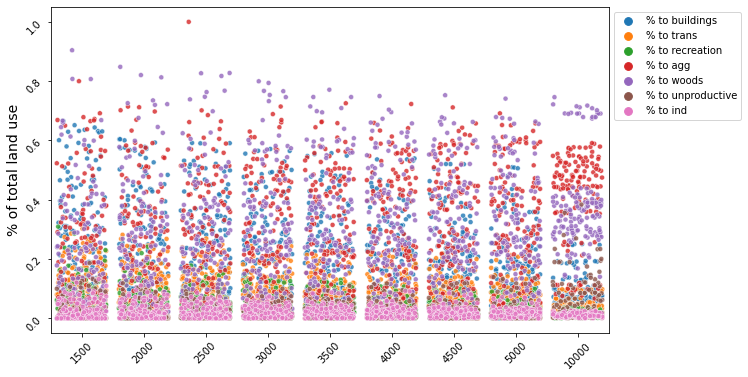

In [62]:
fig, ax = plt.subplots(figsize=(10,6))

props = {
 'boxprops':{'facecolor':'none', 'edgecolor':'black'},
    
}
sns.stripplot(data=xlong, x = 'dist', y='value', hue='variable', ax=ax, jitter=.4, zorder=0, alpha=0.8, edgecolor='white', linewidth=.5)
ax.tick_params(labelrotation=45)
ax.set_ylabel("% of total land use", fontsize=14)
ax.set_xlabel("")
plt.legend(bbox_to_anchor=(1,1), loc='upper left')
plt.show()

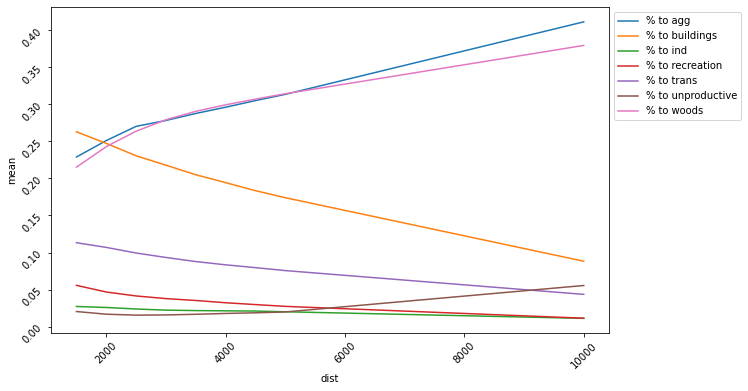

In [63]:
z = xlong.groupby(['variable', 'dist']).value.describe()['mean'].reset_index()
fig, ax = plt.subplots(figsize=(10,6))
sns.lineplot(data=z, x='dist', y='mean', hue='variable')
ax.tick_params(labelrotation=45)
plt.legend(bbox_to_anchor=(1,1), loc='upper left')
plt.show()

## Compare the land use rates for each buffer radius

In [64]:
newdf = pd.concat([lt1500,lt2000, lt2500, lt3000, lt3500, lt4000, lt4500, lt5000, lt10000], axis=1)
newdf.reset_index(inplace=True)
newdf.set_index('index', drop=True, inplace=True)

total ='adjusted_land_use'
totaldf = newdf.loc[total]

landuse = ['agg', 'buildings', 'ind', 'recreation', 'trans', 'unproductive', 'woods']
adf = newdf.loc[landuse].copy()

for element in totaldf.index:
    adf[element] =  adf[element]/totaldf.loc[element]
adf=adf.applymap(lambda x:x*100)
#(lambda x: round(x, 6))
adf

,1500,2000,2500,3000,3500,4000,4500,5000,10000
index,,,,,,,,,
agg,24.360272,25.828389,27.210614,28.418599,29.617958,30.700121,31.795856,32.804375,41.097712
buildings,28.081141,26.453925,24.755525,23.383306,21.934925,20.687196,19.416685,18.330635,8.730764
ind,3.180691,2.912318,2.668672,2.488363,2.389199,2.319857,2.260981,2.150951,1.136382
recreation,5.873425,5.022162,4.498667,4.137763,3.859054,3.500916,3.203230,2.935865,1.140267
trans,12.389843,11.567057,10.745137,10.025709,9.391013,8.887528,8.434686,7.990767,4.394553
unproductive,2.163979,1.797970,1.657786,1.668796,1.767169,1.912908,2.042823,2.203116,5.388770
woods,23.950650,26.418180,28.463599,29.877464,31.040681,31.991473,32.845740,33.584290,38.111553


In [65]:
somtext = F"The sum of the the 1500m column = {adf['1500'].sum()}"

print(somtext)

The sum of the the 1500m column = 100.0


In [66]:
adf.reset_index()

,index,1500,2000,2500,3000,3500,4000,4500,5000,10000
0,agg,24.360272,25.828389,27.210614,28.418599,29.617958,30.700121,31.795856,32.804375,41.097712
1,buildings,28.081141,26.453925,24.755525,23.383306,21.934925,20.687196,19.416685,18.330635,8.730764
2,ind,3.180691,2.912318,2.668672,2.488363,2.389199,2.319857,2.260981,2.150951,1.136382
3,recreation,5.873425,5.022162,4.498667,4.137763,3.859054,3.500916,3.203230,2.935865,1.140267
4,trans,12.389843,11.567057,10.745137,10.025709,9.391013,8.887528,8.434686,7.990767,4.394553
5,unproductive,2.163979,1.797970,1.657786,1.668796,1.767169,1.912908,2.042823,2.203116,5.388770
6,woods,23.950650,26.418180,28.463599,29.877464,31.040681,31.991473,32.845740,33.584290,38.111553


C:\Users\schre086\AppData\Local\Temp/ipykernel_21132/3673239487.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['0','20','40','60','80','100'], fontsize=14)
C:\Users\schre086\AppData\Local\Temp/ipykernel_21132/3673239487.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['1,500','2,000','2,500','3,000','3,500','4,000','4,500','5,000','10,000'],fontsize=13)


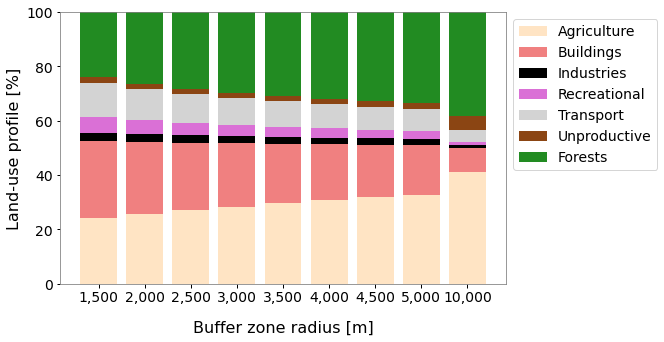

In [68]:
data =adf.values
labels = adf.index
colors = adf.index
xlabels = adf.columns.values

colors = ['bisque','lightcoral','k','orchid','lightgrey','saddlebrown', 'forestgreen']

bottom = [0]*(len(adf.columns))

width = 0.8      # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots(figsize=(8,5))

for i,group in enumerate(data):    
  
    ax.bar(xlabels, group, width, bottom=bottom, label=labels[i], color = colors[i])
    bottom += group


ax.set_ylabel('Land-use profile [%]', fontsize=16)
ax.set_yticklabels(['0','20','40','60','80','100'], fontsize=14)

ax.set_xticklabels(['1,500','2,000','2,500','3,000','3,500','4,000','4,500','5,000','10,000'],fontsize=13)

ax.set_xlabel("Buffer zone radius [m]", labelpad =15, fontsize=16)
ax.set_facecolor('white')


ax.spines['top'].set_color('0.5')
ax.spines['right'].set_color('0.5')
ax.spines['bottom'].set_color('0.5')
ax.spines['left'].set_color('0.5')
ax.set_ylim(0,100)

ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.tick_params(labelcolor='k', labelsize=14, width=1)

plt.legend(['Agriculture','Buildings','Industries','Recreational','Transport','Unproductive','Forests'],bbox_to_anchor=(1,1), facecolor = 'white', fontsize=14)

#plt.show()

plt.savefig('C:/Users/schre086/figures/land_use_ch/land_use_buffer.png', bbox_inches='tight')


In [71]:
survey_data = fd_luse_1500.copy()

In [72]:
survey_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 81832 entries, 0 to 88779
Data columns (total 32 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               81832 non-null  datetime64[ns]
 1   code               81832 non-null  object        
 2   pcs_m              81832 non-null  float64       
 3   quantity           81832 non-null  int64         
 4   location           81832 non-null  object        
 5   loc_date           81832 non-null  object        
 6   water_name_slug    81832 non-null  object        
 7   river_bassin       81832 non-null  object        
 8   length             81832 non-null  float64       
 9   ilength            81832 non-null  float64       
 10  groupname          81832 non-null  object        
 11  city               81832 non-null  object        
 12  population         81832 non-null  float64       
 13  intersects         81832 non-null  int64         
 14  fail  

In [73]:
# explanatory variables that are being considered
#luse_exp = ['% to buildings', '% to recreation', '% to agg', '% to woods', 'streets km', 'intersects']
luse_exp = ['Buildings [%]','Industrial [%]', 'Recreational [%]', 'Agricultural [%]', 'Forests [%]', 'Unproductive [%]', 'Road network \nlength [km]', 'Rivers/canals [#]']
# columns needed
use_these_cols = ['loc_date' ,
                  'date',
                  '% to buildings',
                  '% to trans',
                  '% to recreation',
                  '% to agg',
                  '% to woods',
                  '% to ind', 
                  '% to unproductive',
                  'population',
                  'water_name_slug',
                  'streets km',
                  'intersects',
                  'groupname',
                  'code'
                 ]

# the land use data was unvailable for these municipalities
no_land_use = ['Walenstadt', 'Weesen', 'Glarus Nord', 'Quarten']

# slice the data by start and end date, remove the locations with no land use data
use_these_args = ((survey_data.date >= start_date)&(survey_data.date <= end_date)&(~survey_data.city.isin(no_land_use)))
survey_data = survey_data[use_these_args].copy()

# format the data and column names
survey_data['date'] = pd.to_datetime(survey_data.date)

# work off a copy
new_som_data = survey_data.copy()

# adjust the fail rate for this aggregation of data
new_som_data['fail'] = True
new_som_data.loc[new_som_data.quantity == 0, 'fail'] = False

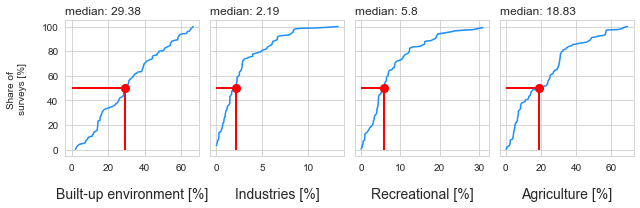

In [79]:
# the survey total for each survey indifferent of object
dfdt = new_som_data.groupby(use_these_cols[:-2], as_index=False).agg({unit_label:'sum', 'quantity':'sum'})


dfdt = new_som_data.groupby(use_these_cols[:-2], as_index=False).agg({unit_label:'sum', 'quantity':'sum'})
dfdt.columns = ['loc_date','date','Built-up environment [%]', '% to tran', 'Recreational [%]', 'Agriculture [%]', 
                'Forests [%]', 'Industries [%]', 'Unproductive land [%]', 'Population', 'water_name_slug', 'Road network \nlength [km]', 'Rivers/canals [#]', 'p/100 m','quantity']

# method to get the ranked correlation of pcs_m to each explanatory variable
def make_plot_with_spearmans(data, ax, n):
    sns.scatterplot(data=data, x=n, y=unit_label, ax=ax, color='black', s=30, edgecolor='white', alpha=0.6)
    corr, a_p = stats.spearmanr(data[n], data[unit_label])
    return ax, corr, a_p

sns.set_style("whitegrid")
fig, axs = plt.subplots(1,4, figsize=(9,3), sharey=True)

data = dfdt.copy()

perc_cols = ['Built-up environment [%]','Industries [%]', 'Recreational [%]', 'Agriculture [%]', 'Forests [%]', 'Unproductive land [%]']

data[perc_cols] = data[perc_cols].apply(lambda x:x*100)

cols1 = ['Built-up environment [%]','Industries [%]', 'Recreational [%]', 'Agriculture [%]']
#cols2 = ['Forests [%]', 'Unproductive [%]', 'Road network \nlength [km]', 'Rivers/canals [#]']
for i, n in enumerate(cols1):
    ax=axs[i]
    
    # the ECDF of the land use variable
    the_data = ECDF(data[n].values)
    sns.lineplot(x=the_data.x, y= (the_data.y)*100, ax=ax, color='dodgerblue', label="% of surface area" )
    
    # get the median % of land use for each variable under consideration from the data
    the_median = data[n].median()
    
    # plot the median and drop horzontal and vertical lines
    ax.scatter([the_median], 50, color='red',s=50, linewidth=2, zorder=100, label="the median")
    ax.vlines(x=the_median, ymin=0, ymax=50, color='red', linewidth=2)
    ax.hlines(xmax=the_median, xmin=0, y=50, color='red', linewidth=2)
    
    #remove the legend from ax   
    ax.get_legend().remove()
    
    if i == 0:
        ax.set_ylabel("Share of \nsurveys [%]", labelpad = 15)
    else:
        pass
    
    # add the median value from all locations to the ax title
    ax.set_title(F"median: {(round(the_median, 2))}",fontsize=12, loc='left')
    ax.set_xlabel(n, fontsize=14, labelpad=15)

plt.tight_layout()

plt.savefig('C:/Users/schre086/figures/land_use_ch/land_use_1500_A.png', bbox_inches='tight')

plt.show()

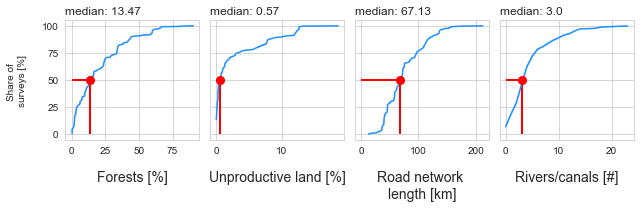

In [80]:
sns.set_style("whitegrid")
fig, axs = plt.subplots(1,4, figsize=(9,3), sharey=True)

#cols1 = ['Buildings [%]','Industrial [%]', 'Recreational [%]', 'Agricultural [%]']
cols2 = ['Forests [%]', 'Unproductive land [%]', 'Road network \nlength [km]', 'Rivers/canals [#]']
for i, n in enumerate(cols2):
    ax=axs[i]
    
    # the ECDF of the land use variable
    the_data = ECDF(data[n].values)
    sns.lineplot(x=the_data.x, y= (the_data.y)*100, ax=ax, color='dodgerblue', label="% of surface area" )
    
    # get the median % of land use for each variable under consideration from the data
    the_median = data[n].median()
    
    # plot the median and drop horzontal and vertical lines
    ax.scatter([the_median], 50, color='red',s=50, linewidth=2, zorder=100, label="the median")
    ax.vlines(x=the_median, ymin=0, ymax=50, color='red', linewidth=2)
    ax.hlines(xmax=the_median, xmin=0, y=50, color='red', linewidth=2)
    
    #remove the legend from ax   
    ax.get_legend().remove()
    
    if i == 0:
        ax.set_ylabel("Share of \nsurveys [%]", labelpad = 15)
    else:
        pass
    
    # add the median value from all locations to the ax title
    ax.set_title(F"median: {(round(the_median, 2))}",fontsize=12, loc='left')
    ax.set_xlabel(n, fontsize=14, labelpad=15)

plt.tight_layout()

plt.savefig('C:/Users/schre086/figures/land_use_ch/land_use_1500_B.png', bbox_inches='tight')

plt.show()